### 0. Imports

In [2]:
import os
import json
import gc
import torch
import torchaudio
import torchvision.io as tvio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from pathlib import Path
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from transformers import (
    Wav2Vec2Model, Wav2Vec2FeatureExtractor,
    BertModel, BertTokenizer,
    ViTModel, ViTImageProcessor
)
from sklearn.utils.class_weight import compute_class_weight
from wordcloud import WordCloud
from torch.utils.tensorboard import SummaryWriter
import subprocess
import warnings
warnings.filterwarnings('ignore')

### 1️ SETUP & PATHS

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [4]:
ROOT = Path("/kaggle/working")
KAGGLE_INPUT = Path("/kaggle/input")

In [5]:
def find_meld_root():
    for p in KAGGLE_INPUT.iterdir():
        if p.is_dir() and "meld" in p.name.lower():
            if list(p.glob("**/train_sent_emo.csv")):
                return p
    return None

In [6]:
MELD_ROOT = find_meld_root()
if not MELD_ROOT:
    raise RuntimeError("MELD dataset not found!")

print(f"Dataset found at: {MELD_ROOT}")

Dataset found at: /kaggle/input/meld-with-audio-files


In [7]:
# Create output directories
OUTPUT_DIR = ROOT / "outputs"
EDA_DIR = OUTPUT_DIR / "EDA_Plots"
LOG_DIR = OUTPUT_DIR / "logs"
MODEL_DIR = OUTPUT_DIR / "models"
RESULTS_DIR = OUTPUT_DIR / "Results"
EMB_DIR = OUTPUT_DIR / "embeddings"

In [8]:
for d in [EDA_DIR, LOG_DIR, MODEL_DIR, RESULTS_DIR, EMB_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print(f"Output directory: {OUTPUT_DIR}")

Output directory: /kaggle/working/outputs


### 2️ LOCATE VIDEO AND CSV FILES

In [9]:
print("\nLocating dataset files...")

# Find CSV files
train_csv = list(MELD_ROOT.glob("**/train_sent_emo.csv"))[0]
dev_csv = list(MELD_ROOT.glob("**/dev_sent_emo.csv"))[0]
test_csv = list(MELD_ROOT.glob("**/test_sent_emo.csv"))[0]


Locating dataset files...


In [10]:
print(f"  Train CSV: {train_csv}")
print(f"  Dev CSV: {dev_csv}")
print(f"  Test CSV: {test_csv}")

  Train CSV: /kaggle/input/meld-with-audio-files/meld-dataset/MELD-RAW/MELD.Raw/train/train_sent_emo.csv
  Dev CSV: /kaggle/input/meld-with-audio-files/meld-dataset/MELD-RAW/MELD.Raw/dev_sent_emo.csv
  Test CSV: /kaggle/input/meld-with-audio-files/meld-dataset/MELD-RAW/MELD.Raw/test_sent_emo.csv


In [11]:
# Find video directories
split_dirs = {}
try:
    split_dirs["train"] = list(MELD_ROOT.glob("**/train_splits"))[0]
    split_dirs["dev"] = list(MELD_ROOT.glob("**/dev_splits_complete"))[0]
    split_dirs["test"] = list(MELD_ROOT.glob(
        "**/output_repeated_splits_test"))[0]

    print(f"  Train videos: {split_dirs['train']}")
    print(f"  Dev videos: {split_dirs['dev']}")
    print(f"  Test videos: {split_dirs['test']}")
except IndexError:
    raise RuntimeError(
        "Could not find video directories. Check dataset structure.")

  Train videos: /kaggle/input/meld-with-audio-files/meld-dataset/MELD-RAW/MELD.Raw/train/train_splits
  Dev videos: /kaggle/input/meld-with-audio-files/meld-dataset/MELD-RAW/MELD.Raw/dev/dev_splits_complete
  Test videos: /kaggle/input/meld-with-audio-files/meld-dataset/MELD-RAW/MELD.Raw/test/output_repeated_splits_test


### 3. EXTRACT AUDIO (.mp4 → .wav)

In [ ]:
# def extract_audio_moviepy(mp4_path, wav_path):
#     """Extract audio from video using MoviePy"""
#     try:
#         video = VideoFileClip(str(mp4_path))
#         audio = video.audio
#         if audio is None:
#             return False
        
#         # Write audio to file (MoviePy automatically handles conversion)
#         audio.write_audiofile(str(wav_path), logger = None)
        
#         # Close resources
#         audio.close()
#         video.close()
#         return True
#     except Exception as e:
#         return False

In [ ]:
# def bulk_extract_audio(video_dir, audio_dir):
#     """Extract audio from all videos in a directory using MoviePy"""
#     audio_dir = Path(audio_dir)
#     audio_dir.mkdir(parents=True, exist_ok=True)
    
#     mp4_files = list(Path(video_dir).glob("*.mp4"))
#     print(f"  Found {len(mp4_files)} videos")
    
#     success_count = 0
#     for mp4 in tqdm(mp4_files, desc=f"  Extracting {Path(video_dir).name}"):
#         wav = audio_dir / (mp4.stem + ".wav")
#         if not wav.exists():
#             if extract_audio_moviepy(mp4, wav):
#                 success_count += 1
#         else:
#             success_count += 1
    
#     print(f" Successfully extracted {success_count}/{len(mp4_files)} audio files")
#     return success_count

In [ ]:
# import subprocess, numpy as np, soundfile as sf
# from pathlib import Path
# from tqdm import tqdm

# def generate_silent_audio(path, duration=1.0, sr=16000):
#     samples = np.zeros(int(duration * sr), dtype=np.float32)
#     sf.write(str(path), samples, sr)

# def extract_audio_ffmpeg(mp4_path, wav_path):
#     cmd = [
#         "ffmpeg", "-y", "-i", str(mp4_path),
#         "-ac", "1", "-ar", "16000", "-vn",
#         "-acodec", "pcm_s16le", str(wav_path)
#     ]
#     result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
#     if "Stream #0:0" in result.stderr and "Audio" in result.stderr:
#         return True
#     else:
#         return False

# def bulk_extract_with_silent_fill(video_dir, audio_dir):
#     audio_dir = Path(audio_dir)
#     audio_dir.mkdir(parents=True, exist_ok=True)
#     mp4_files = list(Path(video_dir).glob("*.mp4"))

#     for mp4 in tqdm(mp4_files, desc="Extracting Audio"):
#         wav = audio_dir / (mp4.stem + ".wav")
#         if not wav.exists():
#             ok = extract_audio_ffmpeg(mp4, wav)
#             if not ok:
#                 generate_silent_audio(wav, duration=1.0)

# # video_dir = Path(r"D:\\final_year_project_data\\meld-dataset\\MELD-RAW\\MELD.Raw\\train\\train_splits")
# # audio_dir = Path(r"D:\final_year_project_data\meld-dataset\MELD-RAW\MELD.Raw\audio\train")
# # bulk_extract_with_silent_fill(video_dir, audio_dir)


In [ ]:
# print("\n Extracting audio from videos...")
# for split_name, vdir in split_dirs.items():
#     print(f"\n{split_name.upper()}:")
#     bulk_extract_with_silent_fill(vdir, MELD_ROOT / f"audio/{split_name}")

### 3️ LOCATE AUDIO FILES (Pre-extracted)

In [12]:
# Find audio directories
audio_dirs = {}
try:
    # Try multiple possible audio folder patterns
    audio_patterns = [
        "**/audio/train", "**/train/audio",
        "**/audio/dev", "**/dev/audio",
        "**/audio/test", "**/test/audio"
    ]

    # Search for train audio
    train_audio_candidates = []
    for pattern in ["**/audio/train", "**/train/audio"]:
        train_audio_candidates.extend(list(MELD_ROOT.glob(pattern)))
    if train_audio_candidates:
        audio_dirs["train"] = train_audio_candidates[0]
    else:
        raise FileNotFoundError("Train audio directory not found")

    # Search for dev audio
    dev_audio_candidates = []
    for pattern in ["**/audio/dev", "**/dev/audio"]:
        dev_audio_candidates.extend(list(MELD_ROOT.glob(pattern)))
    if dev_audio_candidates:
        audio_dirs["dev"] = dev_audio_candidates[0]
    else:
        raise FileNotFoundError("Dev audio directory not found")

    # Search for test audio
    test_audio_candidates = []
    for pattern in ["**/audio/test", "**/test/audio"]:
        test_audio_candidates.extend(list(MELD_ROOT.glob(pattern)))
    if test_audio_candidates:
        audio_dirs["test"] = test_audio_candidates[0]
    else:
        raise FileNotFoundError("Test audio directory not found")

    print(f"Audio directories located:")
    print(f"  Train audio: {audio_dirs['train']}")
    print(f"  Dev audio: {audio_dirs['dev']}")
    print(f"  Test audio: {audio_dirs['test']}")

    # Verify audio files exist
    for split_name, audio_dir in audio_dirs.items():
        wav_files = list(Path(audio_dir).glob("*.wav"))
        print(f"  {split_name.capitalize()}: Found {len(wav_files)} audio files")
        if len(wav_files) == 0:
            print(f"Warning: No .wav files found in {audio_dir}")

except (IndexError, FileNotFoundError) as e:
    print(f"Error locating audio directories: {e}")
    print("\nSearching for any audio files in the dataset...")
    all_audio = list(MELD_ROOT.glob("**/*.wav"))
    if all_audio:
        print(f"  Found {len(all_audio)} .wav files in total")
        print(f"  Sample audio paths:")
        for sample in all_audio[:3]:
            print(f"    - {sample}")
        print("\n Please check your dataset structure and update audio_dirs manually")
    raise RuntimeError(
        "Could not automatically locate audio directories. Please check dataset structure.")

Audio directories located:
  Train audio: /kaggle/input/meld-with-audio-files/meld-dataset/MELD-RAW/MELD.Raw/audio/train
  Dev audio: /kaggle/input/meld-with-audio-files/meld-dataset/MELD-RAW/MELD.Raw/audio/dev
  Test audio: /kaggle/input/meld-with-audio-files/meld-dataset/MELD-RAW/MELD.Raw/audio/test
  Train: Found 9989 audio files
  Dev: Found 1112 audio files
  Test: Found 4807 audio files


### 4️ LOAD AND EXPLORE DATA

In [13]:
print("\nLoading CSV files...")
train_df = pd.read_csv(train_csv)
dev_df = pd.read_csv(dev_csv)
test_df = pd.read_csv(test_csv)


Loading CSV files...


In [14]:
emotion_names = ["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]

train_labels_list = train_df["Emotion"].map({
    "anger": 0, "disgust": 1, "fear": 2, "joy": 3,
    "neutral": 4, "sadness": 5, "surprise": 6
}).tolist()

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(7),
    y=train_labels_list
)

class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)
print("Class weights:", class_weights)


Class weights: tensor([1.2867, 5.2657, 5.3246, 0.8187, 0.3030, 2.0893, 1.1842],
       device='cuda:0')


In [15]:
print(f"  Train: {len(train_df)} samples")
print(f"  Dev: {len(dev_df)} samples")
print(f"  Test: {len(test_df)} samples")

  Train: 9989 samples
  Dev: 1109 samples
  Test: 2610 samples


In [16]:
# Combine for EDA
full_df = pd.concat([
    train_df.assign(split="train"),
    dev_df.assign(split="dev"),
    test_df.assign(split="test")
], ignore_index=True)

### 5️ EXPLORATORY DATA ANALYSIS (EDA)

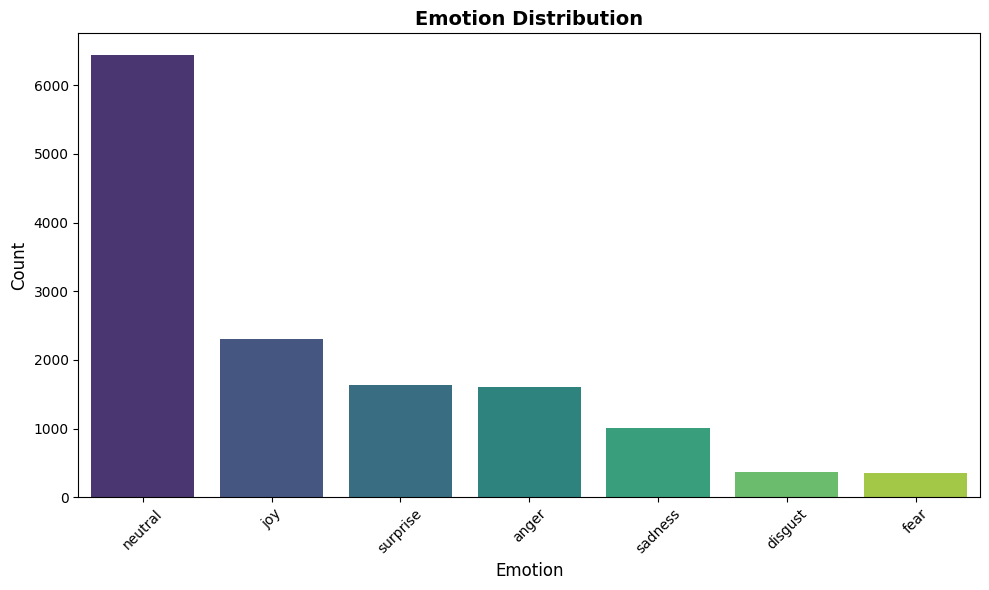

In [32]:
# ============================
# 1. Emotion Distribution
# ============================
plt.figure(figsize=(10, 6))
emotion_counts = full_df["Emotion"].value_counts()
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette="viridis")
plt.title("Emotion Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Emotion", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig(EDA_DIR / "emotion_distribution.png", dpi=300)
plt.close()

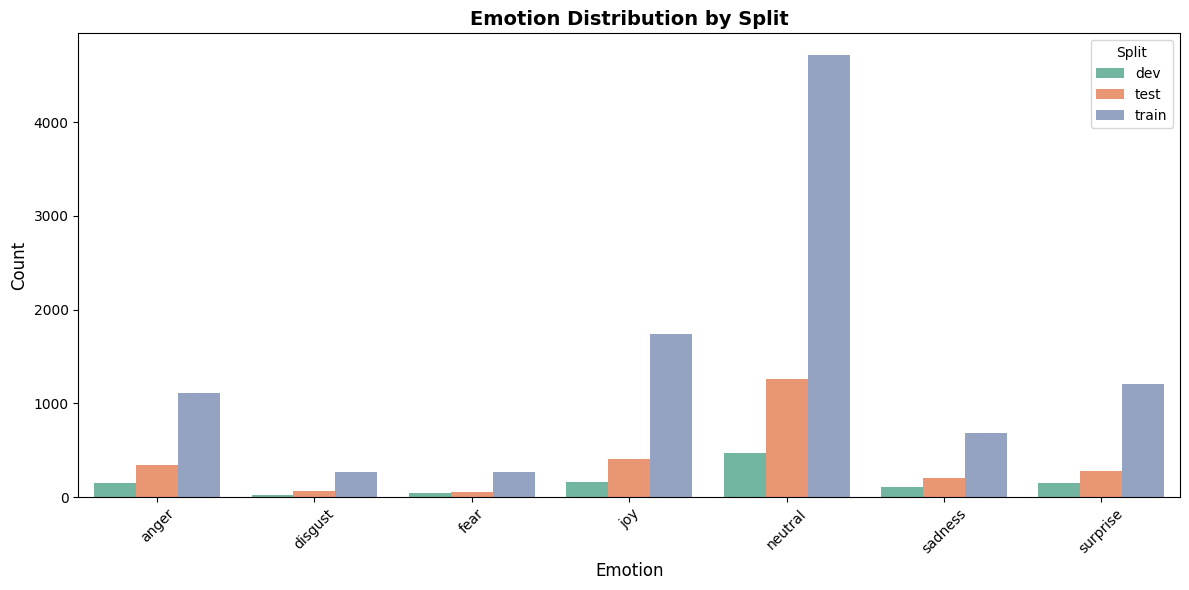

In [33]:
# Distribution by split
plt.figure(figsize=(12, 6))
split_emotion = full_df.groupby(
    ['split', 'Emotion']).size().reset_index(name='count')
sns.barplot(data=split_emotion, x='Emotion',
            y='count', hue='split', palette="Set2")
plt.title("Emotion Distribution by Split", fontsize=14, fontweight='bold')
plt.xlabel("Emotion", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Split")
plt.tight_layout()
plt.show()
plt.savefig(EDA_DIR / "emotion_by_split.png", dpi=300)
plt.close()


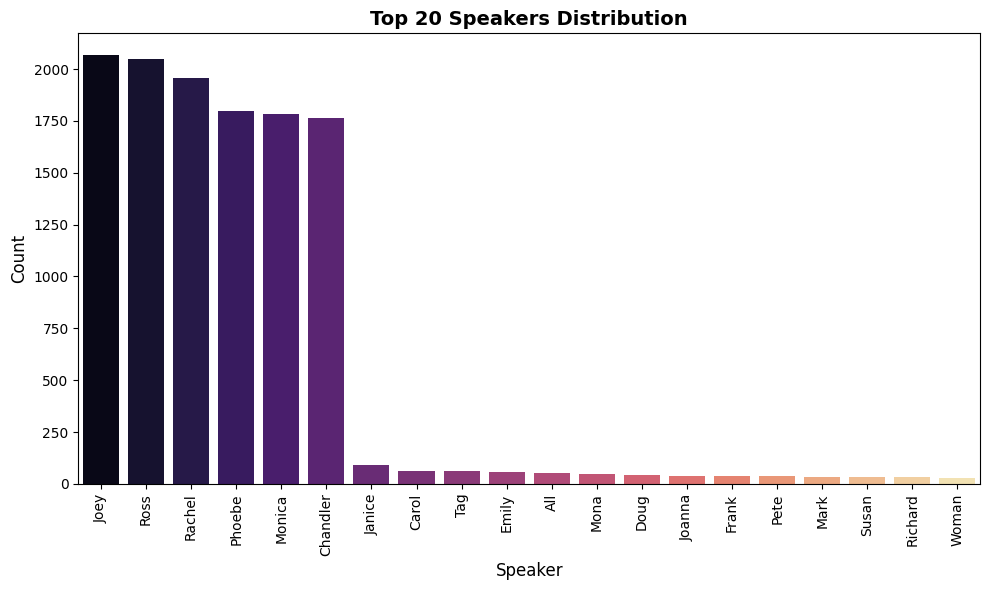

In [34]:
# ============================
# 2. Speaker Distribution
# ============================
plt.figure(figsize=(10, 6))
speaker_counts = full_df["Speaker"].value_counts().head(20)  # top 20 only
sns.barplot(x=speaker_counts.index, y=speaker_counts.values, palette="magma")
plt.title("Top 20 Speakers Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Speaker", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
plt.savefig(EDA_DIR / "speaker_distribution.png", dpi=300)
plt.close()

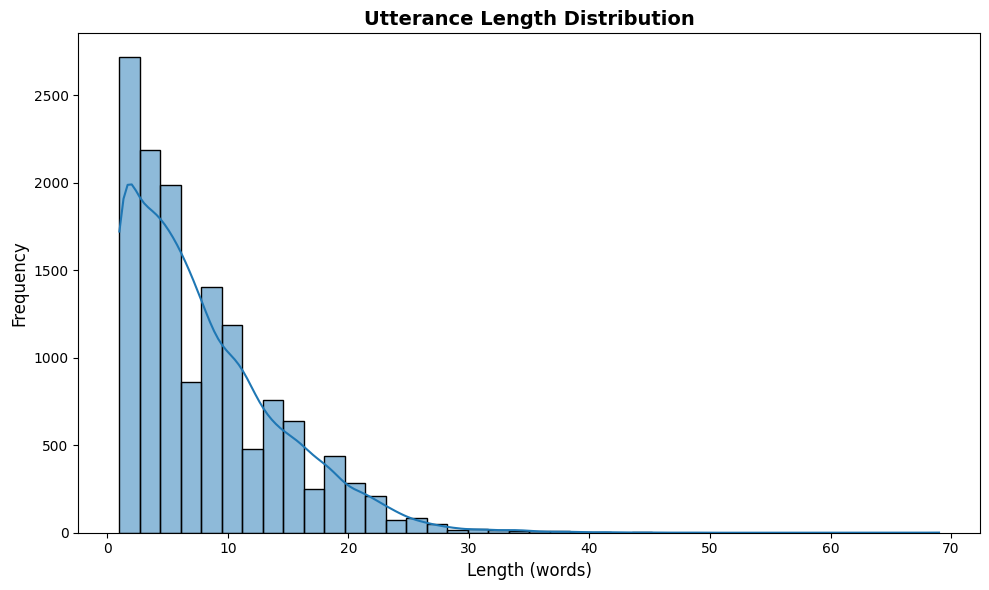

In [35]:
# ============================
# 3. Dialogue Length Distribution
# ============================
plt.figure(figsize=(10, 6))
full_df["Utterance_Length"] = full_df["Utterance"].astype(str).str.split().apply(len)
sns.histplot(full_df["Utterance_Length"], bins=40, kde=True)
plt.title("Utterance Length Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Length (words)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()
plt.savefig(EDA_DIR / "utterance_length_distribution.png", dpi=300)
plt.close()

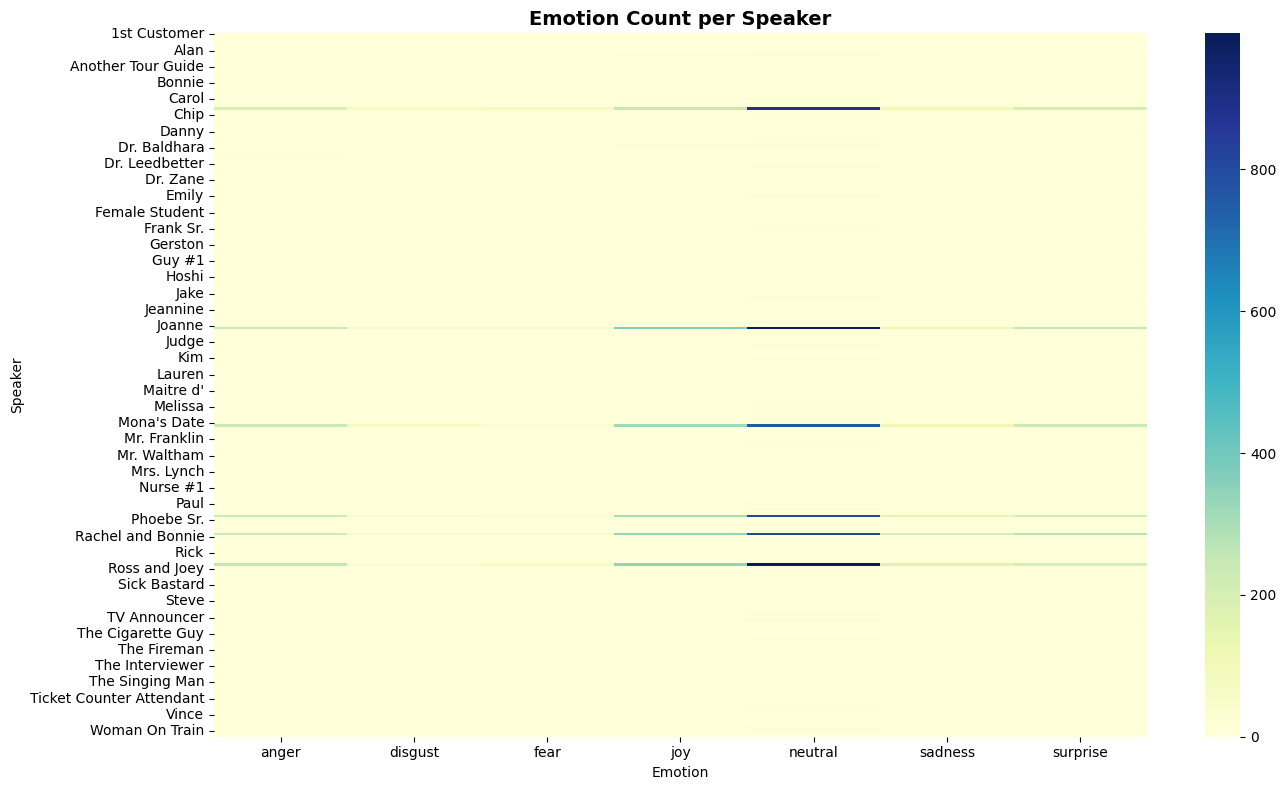

In [36]:
# ============================
# 4. Emotion vs Speaker Heatmap
# ============================
plt.figure(figsize=(14, 8))
pivot_table = pd.crosstab(full_df["Speaker"], full_df["Emotion"])
sns.heatmap(pivot_table, cmap="YlGnBu")
plt.title("Emotion Count per Speaker", fontsize=14, fontweight='bold')
plt.xlabel("Emotion")
plt.ylabel("Speaker")
plt.tight_layout()
plt.show()
plt.savefig(EDA_DIR / "emotion_speaker_heatmap.png", dpi=300)
plt.close()


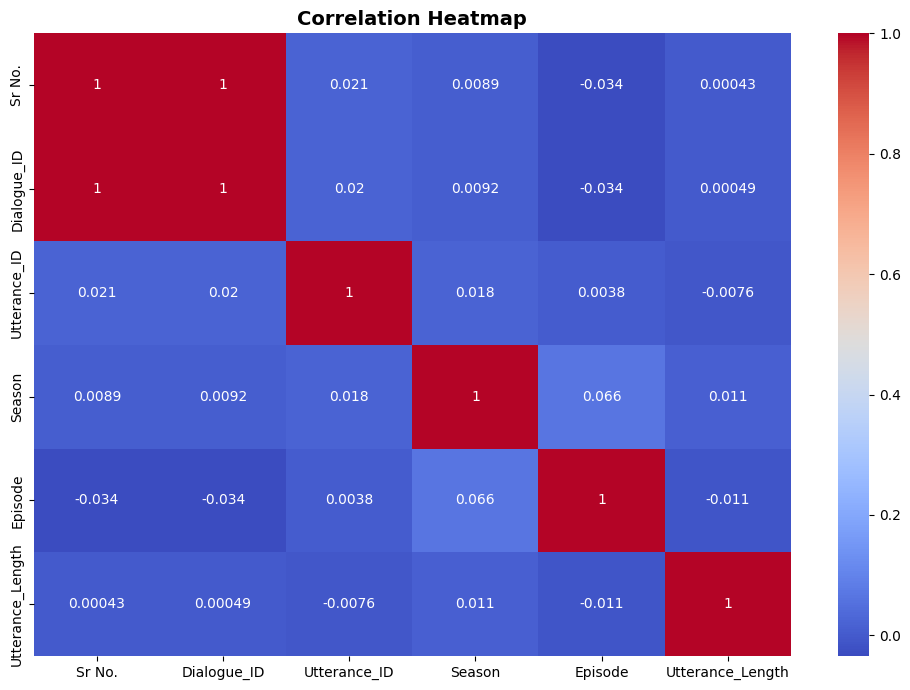

In [37]:
# ============================
# 5. Correlation Heatmap
# ============================
numeric_df = full_df.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(10, 7))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
plt.savefig(EDA_DIR / "correlation_heatmap.png", dpi=300)
plt.close()

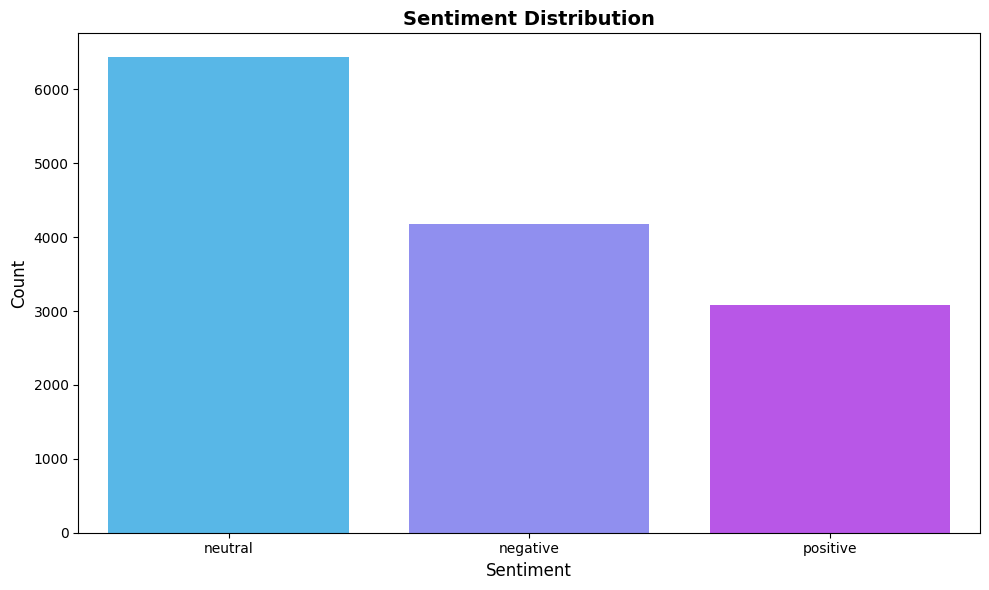

In [38]:
# ============================================================
# 6. Sentiment Distribution
# ============================================================
if "Sentiment" in full_df.columns:
    plt.figure(figsize=(10, 6))
    sentiment_counts = full_df["Sentiment"].value_counts()
    sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="cool")
    plt.title("Sentiment Distribution", fontsize=14, fontweight='bold')
    plt.xlabel("Sentiment", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.tight_layout()
    plt.show()
    plt.savefig(EDA_DIR / "sentiment_distribution.png", dpi=300)
    plt.close()


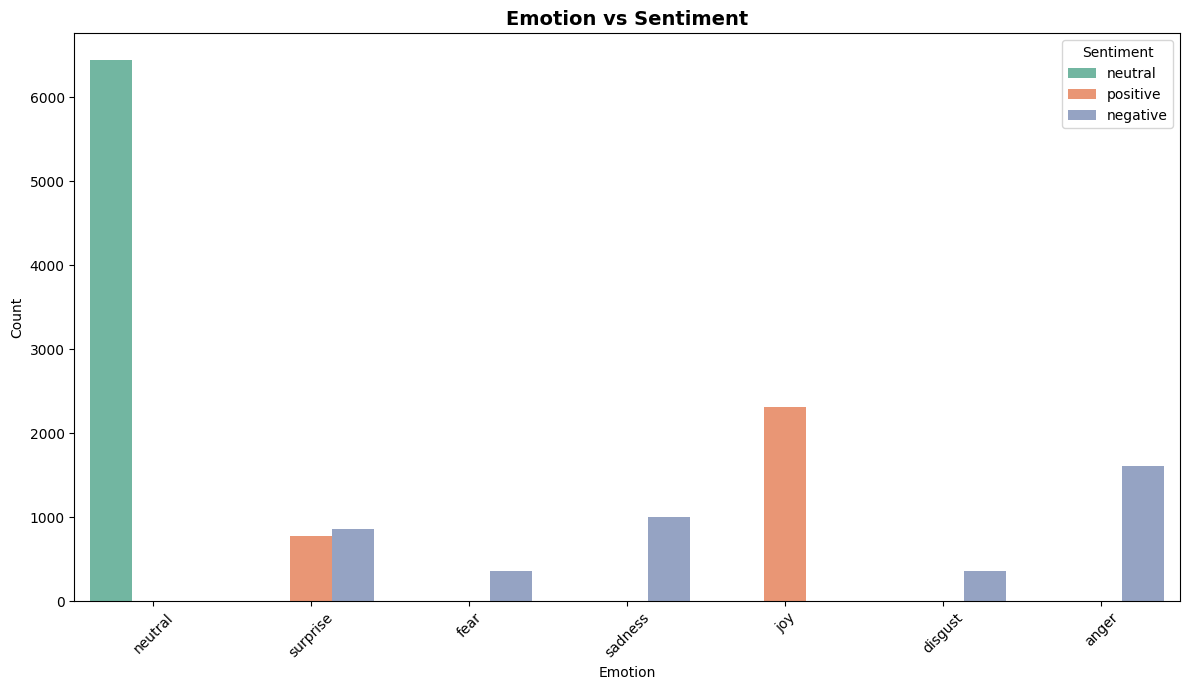

In [39]:
# ============================================================
# 7. Emotion vs Sentiment
# ============================================================
if "Sentiment" in full_df.columns:
    plt.figure(figsize=(12, 7))
    sns.countplot(data=full_df, x="Emotion", hue="Sentiment", palette="Set2")
    plt.title("Emotion vs Sentiment", fontsize=14, fontweight='bold')
    plt.xlabel("Emotion")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    plt.savefig(EDA_DIR / "emotion_vs_sentiment.png", dpi=300)
    plt.close()

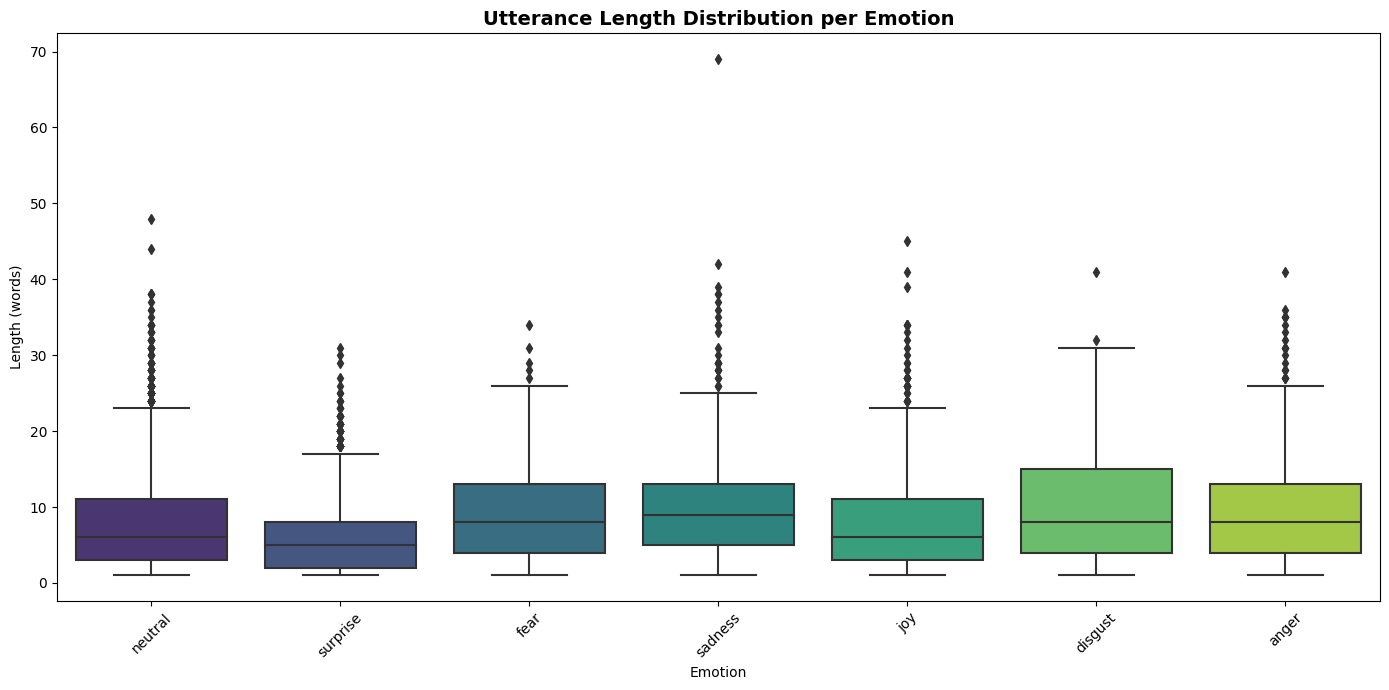

In [40]:
# ============================================================
# 8. Utterance Length per Emotion (Boxplot)
# ============================================================
plt.figure(figsize=(14, 7))
sns.boxplot(data=full_df, x="Emotion", y="Utterance_Length", palette="viridis")
plt.title("Utterance Length Distribution per Emotion", fontsize=14, fontweight='bold')
plt.xlabel("Emotion")
plt.ylabel("Length (words)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig(EDA_DIR / "length_per_emotion_boxplot.png", dpi=300)
plt.close()

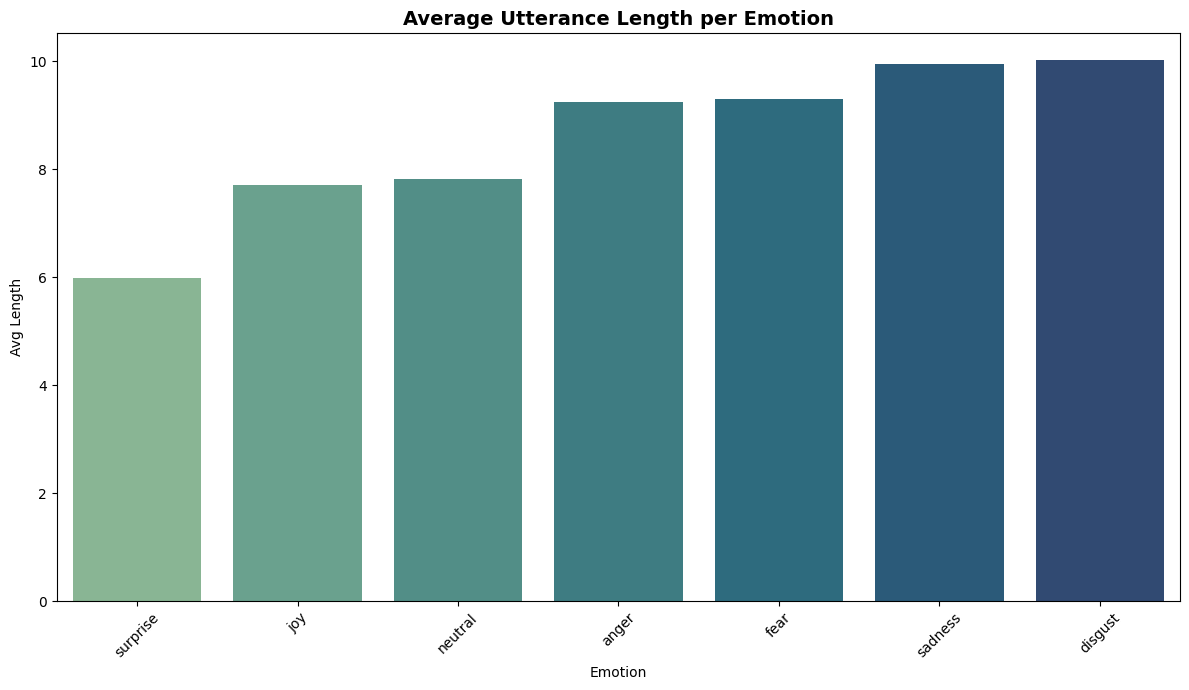

In [41]:
# ============================================================
# 9. Average Utterance Length per Emotion
# ============================================================
plt.figure(figsize=(12, 7))
length_means = full_df.groupby("Emotion")["Utterance_Length"].mean().sort_values()
sns.barplot(x=length_means.index, y=length_means.values, palette="crest")
plt.title("Average Utterance Length per Emotion", fontsize=14, fontweight='bold')
plt.xlabel("Emotion")
plt.ylabel("Avg Length")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig(EDA_DIR / "avg_length_per_emotion.png", dpi=300)
plt.close()

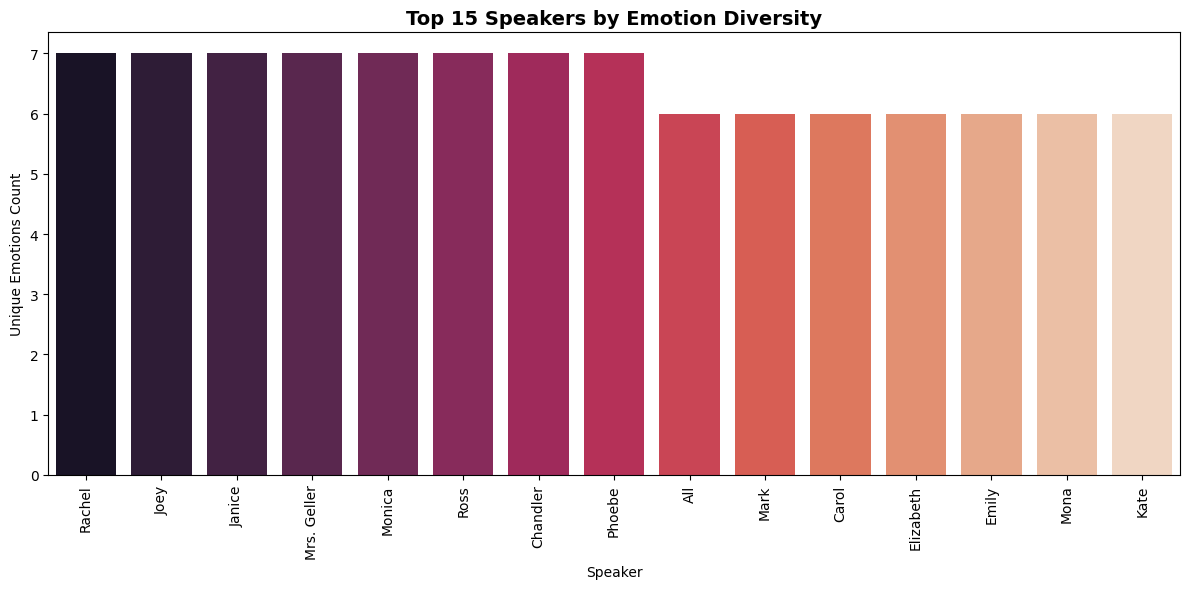

In [42]:
# ============================================================
# 10. Top 15 Speakers by Emotion Diversity
# ============================================================
diversity = full_df.groupby("Speaker")["Emotion"].nunique().sort_values(ascending=False).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x=diversity.index, y=diversity.values, palette="rocket")
plt.title("Top 15 Speakers by Emotion Diversity", fontsize=14, fontweight='bold')
plt.xlabel("Speaker")
plt.ylabel("Unique Emotions Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
plt.savefig(EDA_DIR / "speaker_emotion_diversity.png", dpi=300)
plt.close()


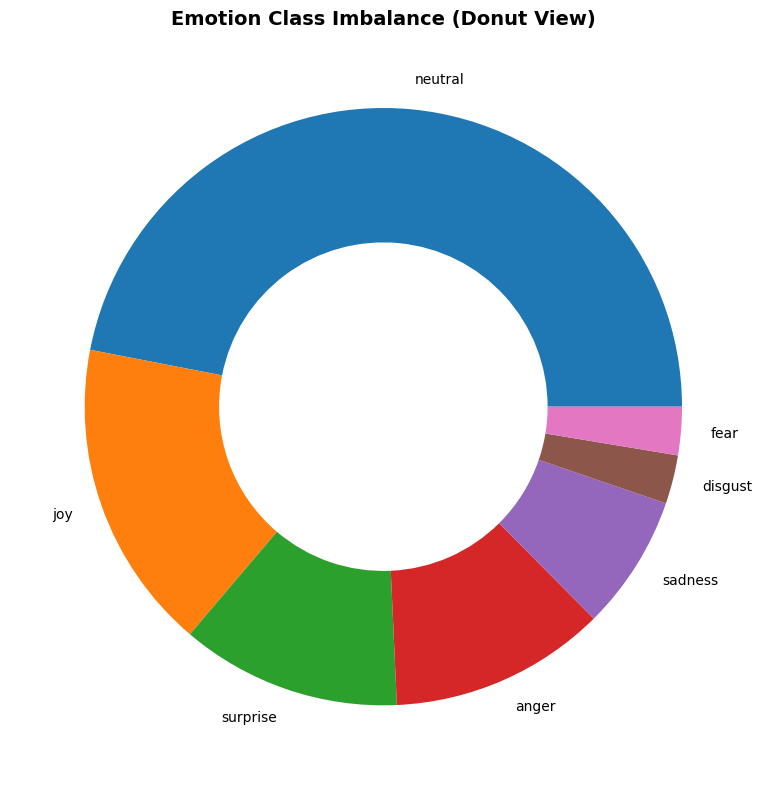

In [43]:
# ============================================================
# 11. Class Imbalance Donut Chart
# ============================================================
plt.figure(figsize=(8, 8))
sizes = emotion_counts.values
labels = emotion_counts.index

plt.pie(sizes, labels=labels, wedgeprops={'width':0.45})
plt.title("Emotion Class Imbalance (Donut View)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
plt.savefig(EDA_DIR / "emotion_donut_chart.png", dpi=300)
plt.close()

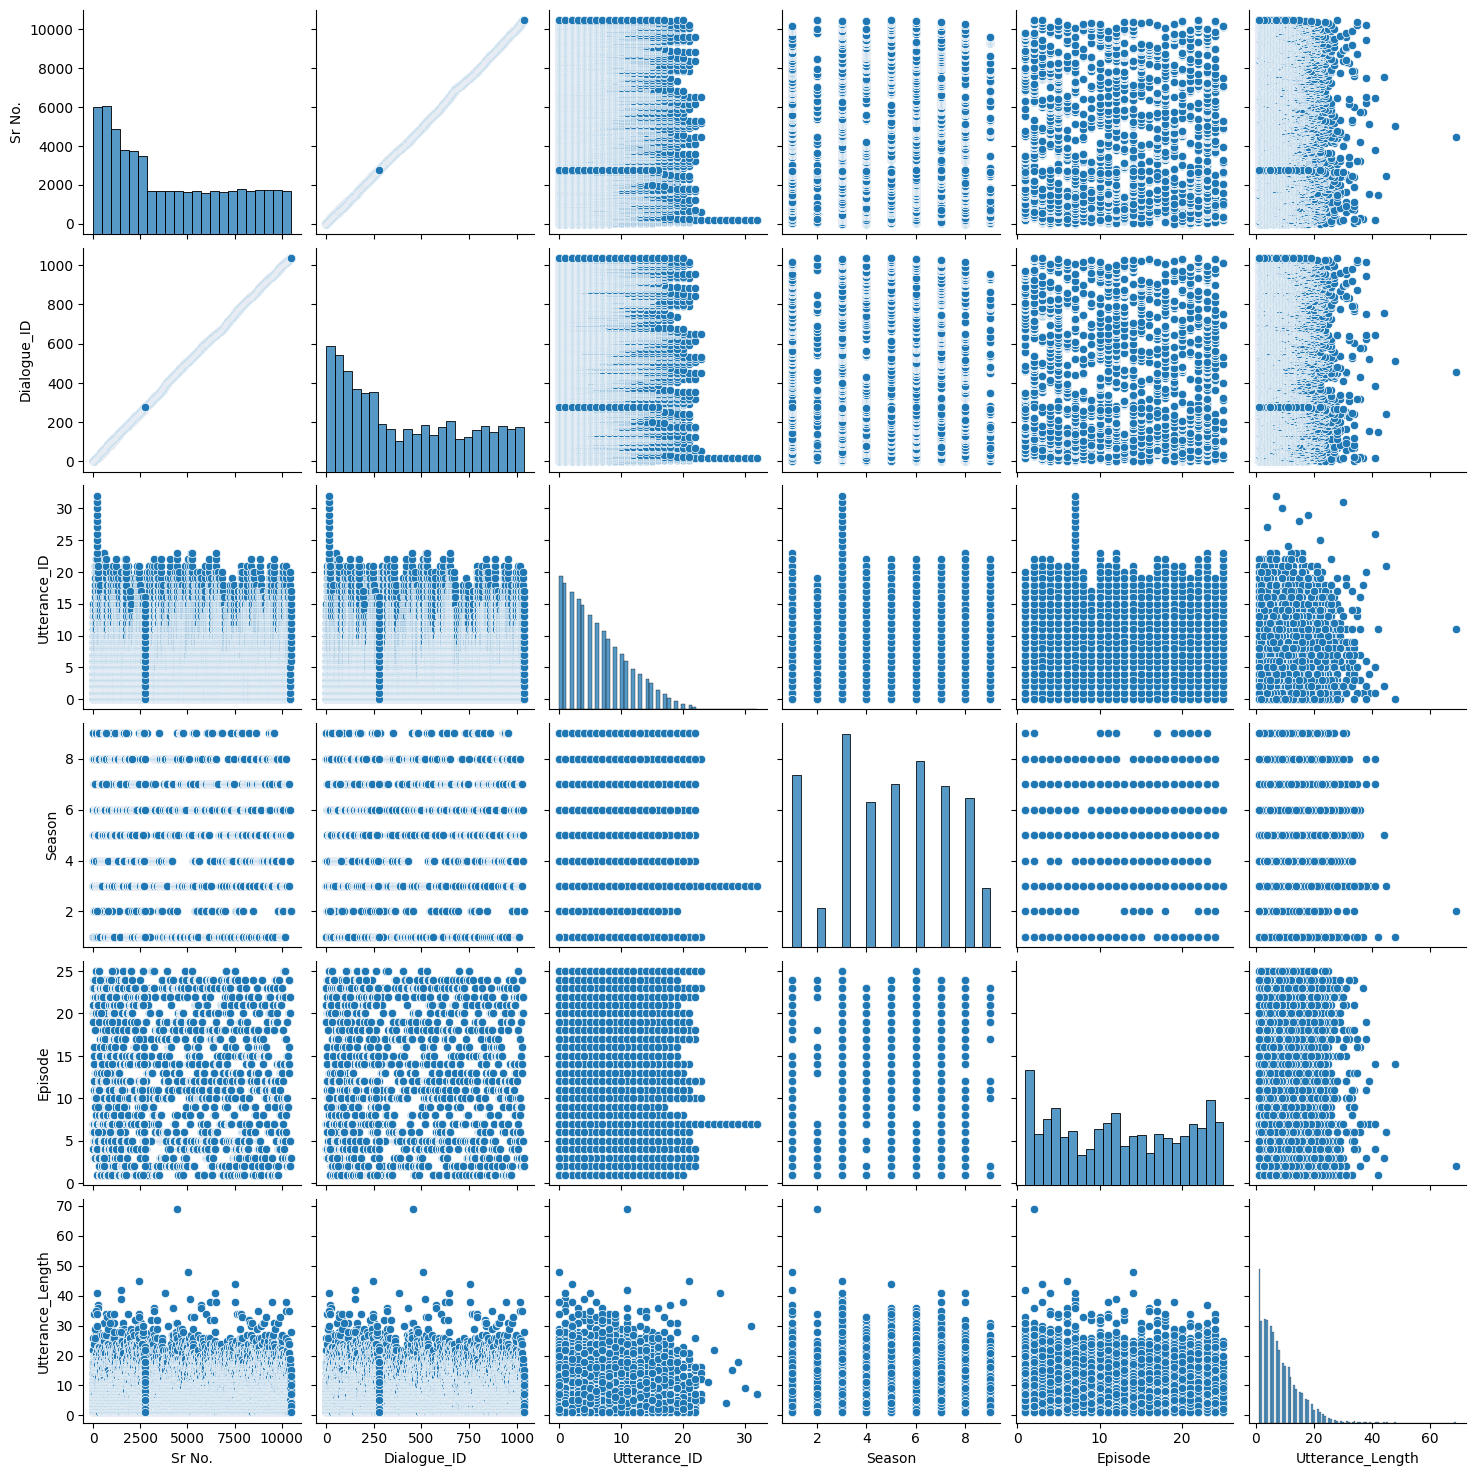

In [44]:
# ============================================================
# 12. Pairplot for Numerical Features
# ============================================================
if numeric_df.shape[1] > 1:
    sns.pairplot(numeric_df)
    plt.show()
    plt.savefig(EDA_DIR / "pairplot_numerical.png", dpi=300)
    plt.close()


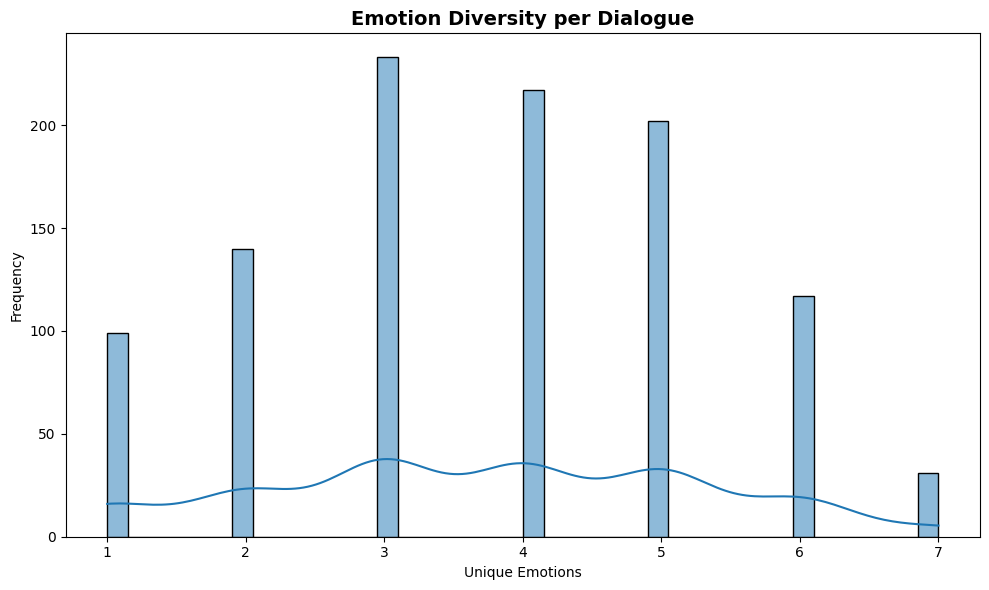

In [45]:
# ============================================================
# 13. Emotion per Dialogue_ID (if exists)
# ============================================================
if "Dialogue_ID" in full_df.columns:
    plt.figure(figsize=(10, 6))
    diag_counts = full_df.groupby("Dialogue_ID")["Emotion"].nunique()
    sns.histplot(diag_counts, bins=40, kde=True)
    plt.title("Emotion Diversity per Dialogue", fontsize=14, fontweight='bold')
    plt.xlabel("Unique Emotions")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
    plt.savefig(EDA_DIR / "emotion_per_dialogue.png", dpi=300)
    plt.close()


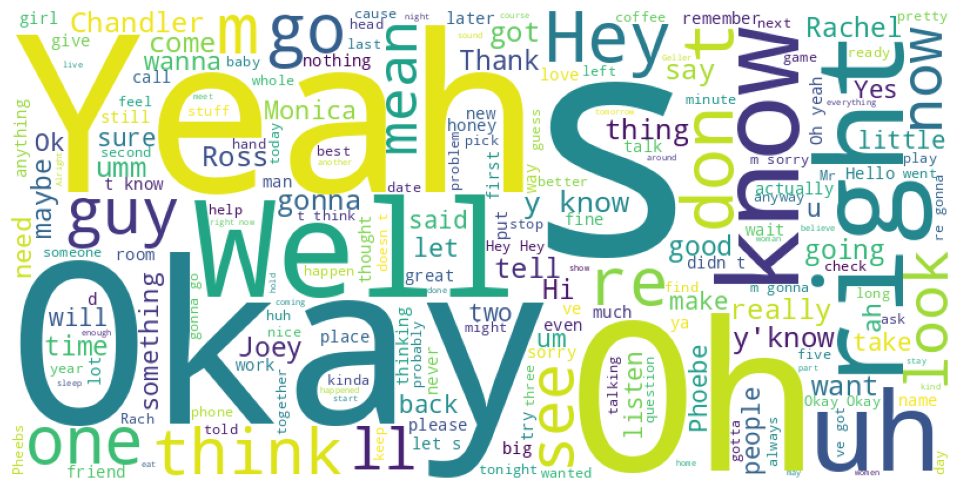

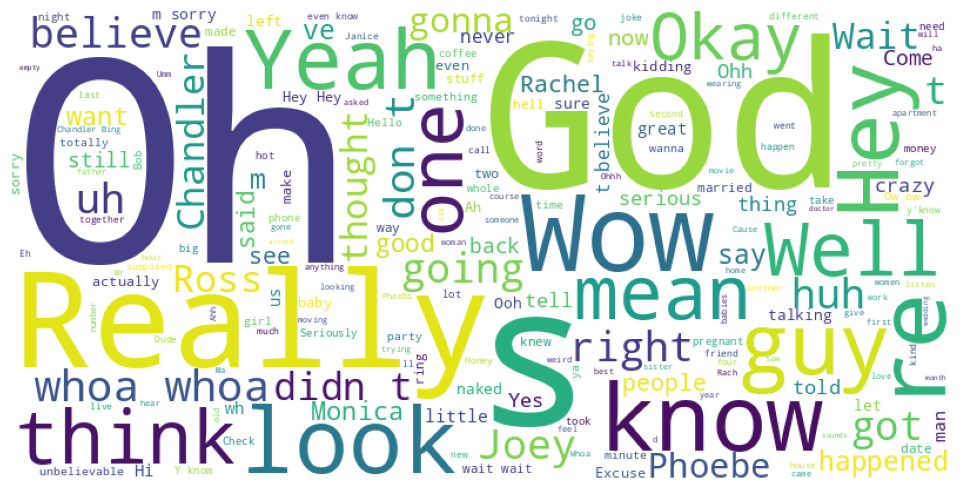

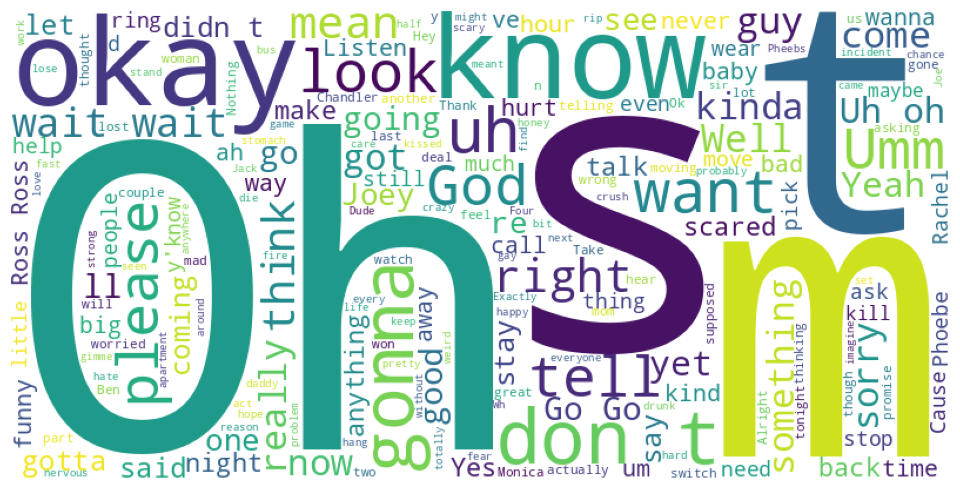

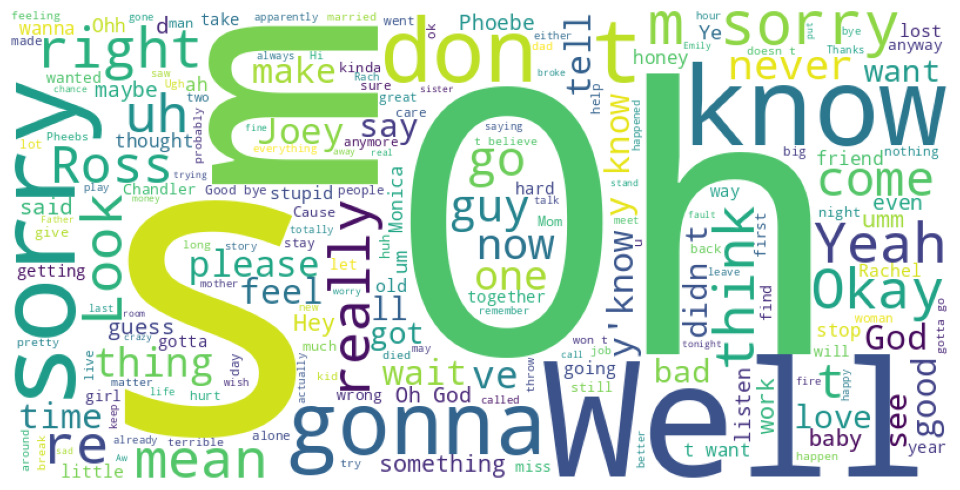

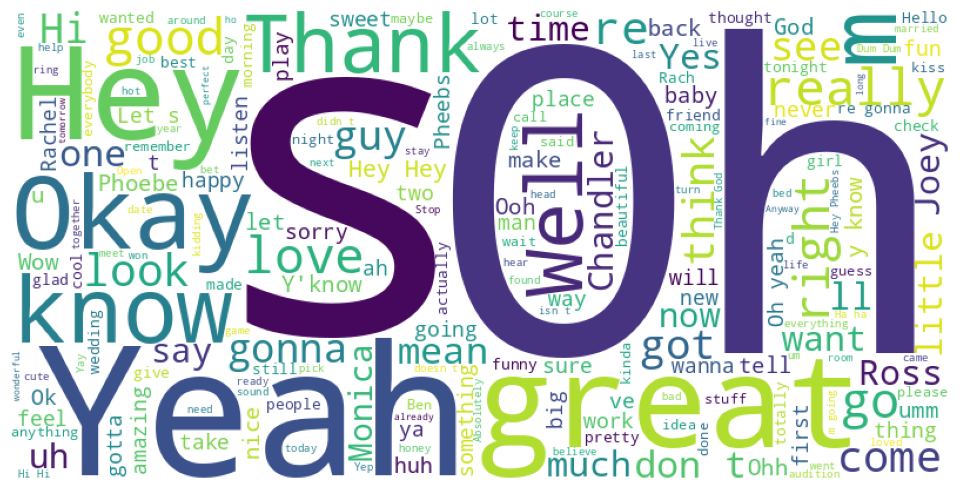

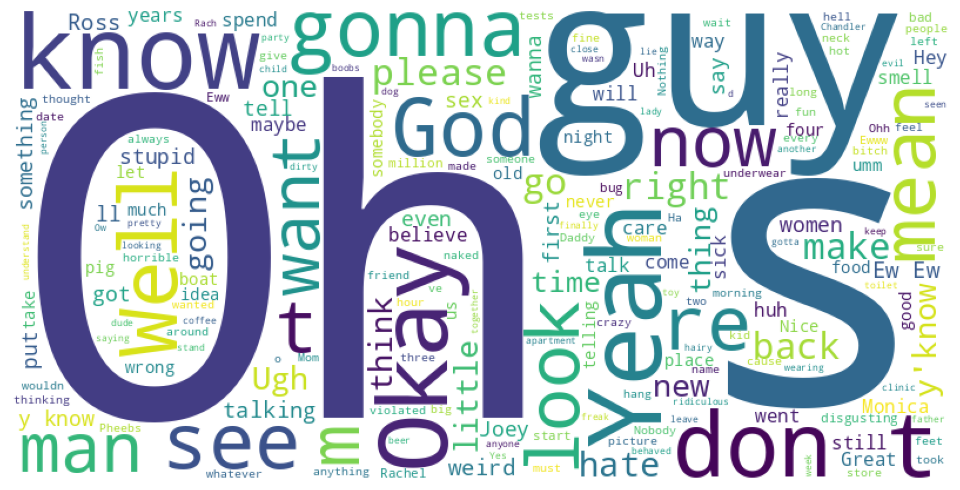

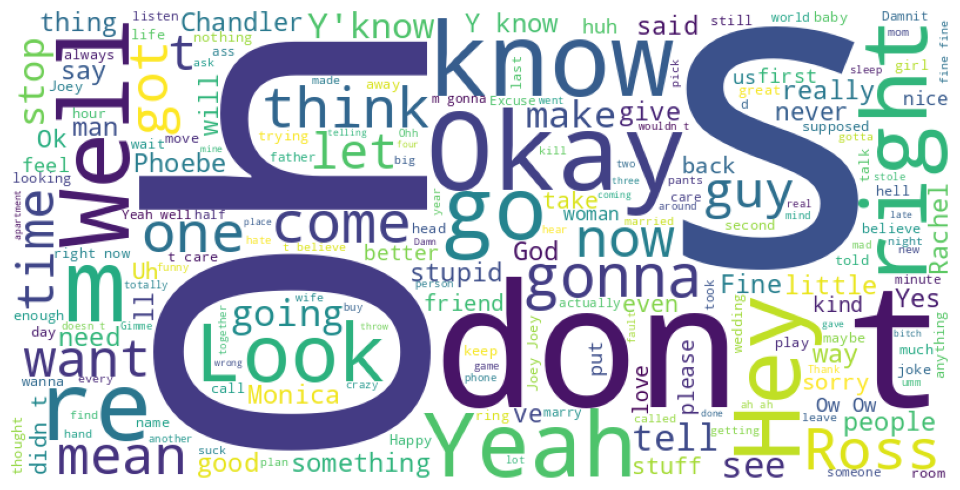

In [46]:
for emo in full_df["Emotion"].unique():
    text = " ".join(full_df[full_df["Emotion"] == emo]["Utterance"].astype(str))
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    plt.savefig(EDA_DIR / f"wordcloud_{emo}.png", dpi=300)
    plt.close()

In [47]:
# Save EDA summary
eda_summary = {
    "train_size": len(train_df),
    "dev_size": len(dev_df),
    "test_size": len(test_df),
    "total_size": len(full_df),
    "emotions": full_df["Emotion"].value_counts().to_dict(),
    "emotion_distribution_by_split": {
        "train": train_df["Emotion"].value_counts().to_dict(),
        "dev": dev_df["Emotion"].value_counts().to_dict(),
        "test": test_df["Emotion"].value_counts().to_dict()
    }
}

with open(OUTPUT_DIR / "eda_summary.json", "w") as f:
    json.dump(eda_summary, f, indent=2)

print(f"EDA complete. Plots saved to {EDA_DIR}")

EDA complete. Plots saved to /kaggle/working/outputs/EDA_Plots


In [ ]:
!zip -r /kaggle/working/EDA_Images.zip /kaggle/working/outputs/EDA_Plots

### 5️ SILENT AUDIO ANALYSIS

In [17]:
def is_silent_audio(waveform, threshold=0.001):
    """Detect if audio is silent (all zeros or near-zero)"""
    if waveform is None or len(waveform) == 0:
        return True
    # Check if RMS energy is below threshold
    rms = np.sqrt(np.mean(waveform**2))
    return rms < threshold

In [49]:
def analyze_silent_audio(df, split_name, audio_dir, video_dir):
    """Analyze how many files have silent audio"""
    silent_count = 0
    real_audio_count = 0
    missing_audio_count = 0
    
    for idx in tqdm(range(min(len(df), 500)), desc=f"Analyzing {split_name}"):  # Sample for speed
        row = df.iloc[idx]
        fname = f"dia{int(row['Dialogue_ID'])}_utt{int(row['Utterance_ID'])}"
        wav_path = audio_dir / f"{fname}.wav"
        
        if wav_path.exists():
            try:
                waveform, sr = torchaudio.load(wav_path)
                if sr != 16000:
                    waveform = torchaudio.transforms.Resample(sr, 16000)(waveform)
                waveform = waveform.mean(0) if waveform.shape[0] > 1 else waveform.squeeze()
                waveform_np = waveform.numpy()
                
                if is_silent_audio(waveform_np):
                    silent_count += 1
                else:
                    real_audio_count += 1
            except:
                missing_audio_count += 1
        else:
            missing_audio_count += 1
    
    total = silent_count + real_audio_count + missing_audio_count
    return {
        "silent": silent_count,
        "real": real_audio_count,
        "missing": missing_audio_count,
        "total": total,
        "silent_percentage": (silent_count / total * 100) if total > 0 else 0,
        "real_percentage": (real_audio_count / total * 100) if total > 0 else 0
    }

In [50]:
# Analyze each split
audio_analysis = {}
for split_name in ["train", "dev", "test"]:
    df = {"train": train_df, "dev": dev_df, "test": test_df}[split_name]
    stats = analyze_silent_audio(df, split_name, audio_dirs[split_name], split_dirs[split_name])
    audio_analysis[split_name] = stats
    
    print(f"\n{split_name.upper()} Split:")
    print(f"  Real audio: {stats['real']} ({stats['real_percentage']:.1f}%)")
    print(f"  Silent audio: {stats['silent']} ({stats['silent_percentage']:.1f}%)")
    print(f"  Missing audio: {stats['missing']}")
    print(f"  Total sampled: {stats['total']}")


Analyzing train:   0%|          | 0/500 [00:00<?, ?it/s]


TRAIN Split:
  Real audio: 499 (99.8%)
  Silent audio: 1 (0.2%)
  Missing audio: 0
  Total sampled: 500


Analyzing dev:   0%|          | 0/500 [00:00<?, ?it/s]


DEV Split:
  Real audio: 499 (99.8%)
  Silent audio: 1 (0.2%)
  Missing audio: 0
  Total sampled: 500


Analyzing test:   0%|          | 0/500 [00:00<?, ?it/s]


TEST Split:
  Real audio: 500 (100.0%)
  Silent audio: 0 (0.0%)
  Missing audio: 0
  Total sampled: 500


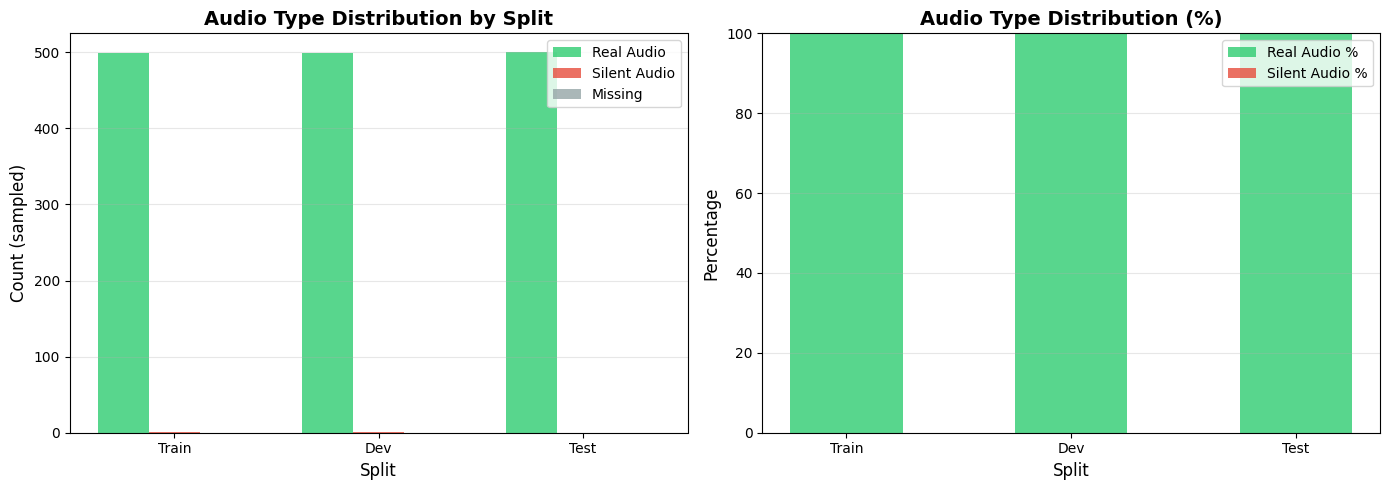

In [51]:
# Visualize audio distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Audio type distribution by split
ax1 = axes[0]
splits = list(audio_analysis.keys())
real_counts = [audio_analysis[s]['real'] for s in splits]
silent_counts = [audio_analysis[s]['silent'] for s in splits]
missing_counts = [audio_analysis[s]['missing'] for s in splits]

x = np.arange(len(splits))
width = 0.25

ax1.bar(x - width, real_counts, width, label='Real Audio', color='#2ecc71', alpha=0.8)
ax1.bar(x, silent_counts, width, label='Silent Audio', color='#e74c3c', alpha=0.8)
ax1.bar(x + width, missing_counts, width, label='Missing', color='#95a5a6', alpha=0.8)

ax1.set_xlabel('Split', fontsize=12)
ax1.set_ylabel('Count (sampled)', fontsize=12)
ax1.set_title('Audio Type Distribution by Split', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([s.capitalize() for s in splits])
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Percentage breakdown
ax2 = axes[1]
real_pcts = [audio_analysis[s]['real_percentage'] for s in splits]
silent_pcts = [audio_analysis[s]['silent_percentage'] for s in splits]

ax2.bar(x, real_pcts, width*2, label='Real Audio %', color='#2ecc71', alpha=0.8)
ax2.bar(x, silent_pcts, width*2, bottom=real_pcts, label='Silent Audio %', color='#e74c3c', alpha=0.8)

ax2.set_xlabel('Split', fontsize=12)
ax2.set_ylabel('Percentage', fontsize=12)
ax2.set_title('Audio Type Distribution (%)', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([s.capitalize() for s in splits])
ax2.legend()
ax2.set_ylim([0, 100])
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()
plt.savefig(EDA_DIR / "silent_audio_analysis.png", dpi=300)
plt.close()

In [52]:
# Save analysis
with open(OUTPUT_DIR / "silent_audio_analysis.json", "w") as f:
    json.dump(audio_analysis, f, indent=2)

print(f"\nSilent audio analysis complete!")
print(f"  Visualization saved: {EDA_DIR / 'silent_audio_analysis.png'}")
print(f"  Statistics saved: {OUTPUT_DIR / 'silent_audio_analysis.json'}")
print(f"\nAudio masking is enabled - silent audio will NOT affect model performance!")


Silent audio analysis complete!
  Visualization saved: /kaggle/working/outputs/EDA_Plots/silent_audio_analysis.png
  Statistics saved: /kaggle/working/outputs/silent_audio_analysis.json

Audio masking is enabled - silent audio will NOT affect model performance!


### 7️ LOAD PRE-TRAINED MODELS

In [ ]:
# print("Loading pretrained models...")
# bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# bert_model = BertModel.from_pretrained("bert-base-uncased").to(DEVICE)
# wav_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base")
# wav2vec_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base").to(DEVICE)
# vit_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
# vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224").to(DEVICE)

# for model in [bert_model, wav2vec_model, vit_model]:
#     model.eval()
#     for p in model.parameters():
#         p.requires_grad = False

In [18]:
print("Loading pretrained models...")
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(DEVICE)
wav_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base")
wav2vec_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base").to(DEVICE)
vit_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224").to(DEVICE)

# Freeze Wav2Vec & ViT completely
for model in [wav2vec_model, vit_model, bert_model]:
    model.eval()
    for p in model.parameters():
        p.requires_grad = False

# # Freeze MOST of BERT, unfreeze last 2 layers
# for name, param in bert_model.named_parameters():
#     param.requires_grad = False
#     if "encoder.layer.11" in name or "encoder.layer.10" in name:
#         param.requires_grad = True


Loading pretrained models...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 1️1️ HELPER FUNCTIONS

In [ ]:
# import os

# file_path = ["/kaggle/working/outputs/embeddings/train_embeddings.pt","/kaggle/working/outputs/embeddings/dev_embeddings.pt"]
# for file in file_path:
#     if os.path.exists(file):
#         os.remove(file)
#         print("File deleted!")
#     else:
#         print("File not found.")


In [19]:
def compute_embeddings(df, split):
    """Compute and save embeddings for a given split."""
    save_path = EMB_DIR / f"{split}_embeddings.pt"
    if save_path.exists():
        print(f" {split} embeddings already exist, skipping.")
        return

    all_text, all_audio, all_video, all_labels, all_mask = [], [], [], [], []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Embedding {split}"):
        fname = f"dia{int(row['Dialogue_ID'])}_utt{int(row['Utterance_ID'])}"

        # --- TEXT ---
        text = str(row["Utterance"])
        tok = bert_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=64).to(DEVICE)
        with torch.no_grad():
            text_emb = bert_model(**tok).last_hidden_state[:, 0]   # CLS token

        # --- AUDIO ---
        wav_path = audio_dirs[split] / f"{fname}.wav"
        if wav_path.exists():
            waveform, sr = torchaudio.load(wav_path)
            if sr != 16000:
                waveform = torchaudio.transforms.Resample(sr, 16000)(waveform)
            waveform = waveform.mean(0).numpy()
            audio_mask = is_silent_audio(waveform)
        else:
            waveform = np.zeros(16000 * 2)
            audio_mask = True

        audio_input = wav_extractor(waveform, sampling_rate=16000, return_tensors="pt", padding=True).to(DEVICE)
        with torch.no_grad():
            audio_emb = wav2vec_model(**audio_input).last_hidden_state.mean(1)

        # --- VIDEO ---
        mp4_path = split_dirs[split] / f"{fname}.mp4"
        try:
            frame, _, _ = tvio.read_video(str(mp4_path), start_pts=1.0, end_pts=1.1, pts_unit="sec")
            frame = frame[0] if len(frame) > 0 else np.zeros((224, 224, 3), dtype=np.uint8)
        except Exception:
            frame = np.zeros((224, 224, 3), dtype=np.uint8)
        vid_input = vit_processor(images=frame, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            video_emb = vit_model(**vid_input).last_hidden_state[:, 0]

        # --- LABEL ---
        label_map = {"anger": 0, "disgust": 1, "fear": 2, "joy": 3, "neutral": 4, "sadness": 5, "surprise": 6}
        label = label_map.get(row["Emotion"], 4)

        all_text.append(text_emb.cpu())
        all_audio.append(audio_emb.cpu())
        all_video.append(video_emb.cpu())
        all_labels.append(torch.tensor(label))
        all_mask.append(torch.tensor(audio_mask))

        del text_emb, audio_emb, video_emb
        gc.collect()

    torch.save({
        "text": torch.cat(all_text),
        "audio": torch.cat(all_audio),
        "video": torch.cat(all_video),
        "labels": torch.stack(all_labels),
        "audio_mask": torch.stack(all_mask)
    }, save_path)
    print(f" Saved {split} embeddings to {save_path}")

In [ ]:
compute_embeddings(train_df, "train")
compute_embeddings(dev_df, "dev")
compute_embeddings(test_df, "test")


In [ ]:
!zip -r /kaggle/working/Outputs.zip /kaggle/working/outputs

In [ ]:
del bert_model, wav2vec_model, vit_model
gc.collect()
torch.cuda.empty_cache()

### 6️ DATASET CLASS

In [20]:
class EmbeddingDataset(Dataset):
    def __init__(self, path):
        data = torch.load(path)
        self.text = data["text"]
        self.audio = data["audio"]
        self.video = data["video"]
        self.labels = data["labels"]
        self.audio_mask = data["audio_mask"]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, i):
        return (
            self.text[i],
            self.audio[i],
            self.video[i],
            self.labels[i],
            self.audio_mask[i]
        )

### 9️ CREATE DATALOADERS

In [186]:
# train_dataset = EmbeddingDataset(EMB_DIR / "train_embeddings.pt")
# dev_dataset   = EmbeddingDataset(EMB_DIR / "dev_embeddings.pt")

train_dataset = EmbeddingDataset("/kaggle/input/final-embeddings/embeddings/train_embeddings.pt")
dev_dataset   = EmbeddingDataset("/kaggle/input/final-embeddings/embeddings/dev_embeddings.pt")
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
dev_loader   = DataLoader(dev_dataset, batch_size=256, shuffle=False)

### 8️ FUSION MODEL

In [22]:
class CrossModalFusion(nn.Module):
    def __init__(self, hidden_dim=768, num_classes=7, dropout=0.4):
        super().__init__()
        self.proj_text = nn.Linear(hidden_dim, hidden_dim)
        self.proj_audio = nn.Linear(hidden_dim, hidden_dim)
        self.proj_video = nn.Linear(hidden_dim, hidden_dim)

        self.cross_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=6, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_dim)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 3, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, text, audio, video, audio_mask=None):
        text = self.proj_text(text)
        audio = self.proj_audio(audio)
        video = self.proj_video(video)
    
        if audio_mask is not None:
            mask = audio_mask.unsqueeze(1).float()
            audio = audio * (1 - mask)
    
        x = torch.stack([text, audio, video], dim=1)
    
        # IMPORTANT: request raw, per-head attention weights
        attn_out, attn_weights = self.cross_attention(
            x, x, x,
            need_weights=True,
            average_attn_weights=False
        )
    
        # store raw attention weights for later visualization
        self.last_attention = attn_weights  # shape: (batch, heads, 3, 3)
    
        out = self.layer_norm(attn_out)
        fused = out.flatten(1)
        logits = self.classifier(fused)
        return logits



In [ ]:
# class CrossModalFusion(nn.Module):
#     def __init__(self, hidden_dim=768, num_classes=7, dropout=0.5):
#         super().__init__()

#         # --- Linear projections ---
#         self.proj_text = nn.Linear(hidden_dim, hidden_dim)
#         self.proj_audio = nn.Linear(hidden_dim, hidden_dim)
#         self.proj_video = nn.Linear(hidden_dim, hidden_dim)

#         # --- Modality dropout ---
#         self.mod_dropout = nn.Dropout(0.2)  # 20% modality dropout

#         # --- Learnable gating network ---
#         self.gate = nn.Sequential(
#             nn.Linear(hidden_dim * 3, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, 3),
#             nn.Softmax(dim=-1)
#         )

#         # --- Attention Layer ---
#         self.cross_attention = nn.MultiheadAttention(
#             embed_dim=hidden_dim,
#             num_heads=4,
#             batch_first=True
#         )
#         self.layer_norm = nn.LayerNorm(hidden_dim)

#         # --- Classifier ---
#         self.classifier = nn.Sequential(
#             nn.Linear(hidden_dim * 3, 512),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(512, 256),
#             nn.ReLU(),
#             nn.Dropout(dropout),
#             nn.Linear(256, num_classes)
#         )

#     def forward(self, text, audio, video, audio_mask=None):
#         # --- Project ---
#         t = self.proj_text(text)
#         a = self.proj_audio(audio)
#         v = self.proj_video(video)

#         # --- Apply modality dropout ---
#         t = self.mod_dropout(t)
#         a = self.mod_dropout(a)
#         v = self.mod_dropout(v)

#         # --- Handle silent or missing audio ---
#         if audio_mask is not None:
#             a = a * (~audio_mask).float().unsqueeze(1)

#         # --- Compute gating weights ---
#         concat = torch.cat([t, a, v], dim=1)  # [B, 768*3]
#         gate_weights = self.gate(concat)      # [B, 3]

#         # --- Apply gating ---
#         t = t * gate_weights[:, 0:1]
#         a = a * gate_weights[:, 1:2]
#         v = v * gate_weights[:, 2:3]

#         # --- Cross-attention ---
#         x = torch.stack([t, a, v], dim=1)
#         attn_out, _ = self.cross_attention(x, x, x)
#         out = self.layer_norm(attn_out)

#         # --- Final fused representation ---
#         fused = out.flatten(1)

#         # --- Classification ---
#         return self.classifier(fused)


### 10 TRAINING SETUP

In [192]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction="mean"):
        """
        alpha: class weights (Tensor of shape [num_classes])
        gamma: focusing parameter (2.0 is standard)
        """
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(weight=alpha, reduction="none")

    def forward(self, logits, labels):
        ce_loss = self.ce(logits, labels)  # per-sample CE loss

        # p_t = softmax probability of the true class
        pt = torch.softmax(logits, dim=1)
        pt = pt[torch.arange(len(labels)), labels]

        focal_term = (1 - pt) ** self.gamma
        loss = focal_term * ce_loss

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:
            return loss


In [24]:
fusion_model = CrossModalFusion().to(DEVICE)
optimizer = AdamW(fusion_model.parameters(), lr=0.0001, weight_decay = 0.05)
# optimizer = AdamW(
#     list(fusion_model.parameters()) + 
#     [p for p in bert_model.parameters() if p.requires_grad],
#     lr=5e-5, weight_decay = 0.05
# )
# criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(weight=class_weights)
# criterion = FocalLoss(alpha=class_weights, gamma=2.0)
alpha = class_weights ** 0.5
criterion = FocalLoss(alpha=alpha, gamma=1.5)
scaler = GradScaler()
writer = SummaryWriter(OUTPUT_DIR / "logs")

EPOCHS = 15
best_f1 = 0

In [25]:
train_losses = []
dev_accuracies = []
dev_f1_scores = []

### 1️2️ TRAINING LOOP

In [26]:
for epoch in range(EPOCHS):
    fusion_model.train()
    running_loss, all_preds, all_labels = 0, [], []

    for text, audio, video, labels, audio_mask in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        text, audio, video, labels, audio_mask = text.to(DEVICE), audio.to(DEVICE), video.to(DEVICE), labels.to(DEVICE), audio_mask.to(DEVICE)

        optimizer.zero_grad(set_to_none=True)
        with autocast(dtype=torch.float16):
            logits = fusion_model(text, audio, video, audio_mask)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        preds = logits.argmax(1)
        running_loss += loss.item()
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

        del text, audio, video, logits, loss
        torch.cuda.empty_cache()
        gc.collect()

    train_acc = accuracy_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds, average="weighted")
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # ===== Validation =====
    fusion_model.eval()
    dev_preds, dev_labels = [], []
    with torch.no_grad():
        for text, audio, video, labels, audio_mask in tqdm(dev_loader, desc="Validation"):
            text, audio, video, labels, audio_mask = text.to(DEVICE), audio.to(DEVICE), video.to(DEVICE), labels.to(DEVICE), audio_mask.to(DEVICE)
            with autocast(dtype=torch.float16):
                logits = fusion_model(text, audio, video, audio_mask)
            preds = logits.argmax(1)
            dev_preds.extend(preds.cpu().tolist())
            dev_labels.extend(labels.cpu().tolist())
            del text, audio, video, logits
            gc.collect()

    dev_acc = accuracy_score(dev_labels, dev_preds)
    dev_f1 = f1_score(dev_labels, dev_preds, average="weighted")
    dev_accuracies.append(dev_acc)
    dev_f1_scores.append(dev_f1)

    print(f"\nEpoch {epoch+1} Summary:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}")
    print(f"Dev Acc: {dev_acc:.4f} | Dev F1: {dev_f1:.4f}")

    if dev_f1 > best_f1:
        best_f1 = dev_f1
        torch.save({
            "epoch": epoch,
            "model_state_dict": fusion_model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "best_f1": best_f1
        }, MODEL_DIR / "best_model.pt")
        print(f"Saved new best model (F1={best_f1:.4f})")

    writer.add_scalar("Train/F1", train_f1, epoch)
    writer.add_scalar("Dev/F1", dev_f1, epoch)

    gc.collect()
    torch.cuda.empty_cache()

writer.close()
print("Training Complete!")

Epoch 1/15:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 1 Summary:
Train Loss: 1.2042 | Train Acc: 0.4820 | Train F1: 0.4146
Dev Acc: 0.5338 | Dev F1: 0.4835
Saved new best model (F1=0.4835)


Epoch 2/15:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 2 Summary:
Train Loss: 0.9975 | Train Acc: 0.5669 | Train F1: 0.5445
Dev Acc: 0.5591 | Dev F1: 0.5188
Saved new best model (F1=0.5188)


Epoch 3/15:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 3 Summary:
Train Loss: 0.9558 | Train Acc: 0.5828 | Train F1: 0.5667
Dev Acc: 0.5825 | Dev F1: 0.5531
Saved new best model (F1=0.5531)


Epoch 4/15:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 4 Summary:
Train Loss: 0.9488 | Train Acc: 0.5978 | Train F1: 0.5881
Dev Acc: 0.5726 | Dev F1: 0.5585
Saved new best model (F1=0.5585)


Epoch 5/15:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 5 Summary:
Train Loss: 0.9152 | Train Acc: 0.5871 | Train F1: 0.5831
Dev Acc: 0.5573 | Dev F1: 0.5354


Epoch 6/15:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 6 Summary:
Train Loss: 0.8704 | Train Acc: 0.5979 | Train F1: 0.5949
Dev Acc: 0.5482 | Dev F1: 0.5397


Epoch 7/15:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 7 Summary:
Train Loss: 0.8671 | Train Acc: 0.5961 | Train F1: 0.5942
Dev Acc: 0.5726 | Dev F1: 0.5590
Saved new best model (F1=0.5590)


Epoch 8/15:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 8 Summary:
Train Loss: 0.8542 | Train Acc: 0.6033 | Train F1: 0.6029
Dev Acc: 0.5338 | Dev F1: 0.5380


Epoch 9/15:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 9 Summary:
Train Loss: 0.8228 | Train Acc: 0.5921 | Train F1: 0.5947
Dev Acc: 0.5717 | Dev F1: 0.5596
Saved new best model (F1=0.5596)


Epoch 10/15:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 10 Summary:
Train Loss: 0.8132 | Train Acc: 0.6106 | Train F1: 0.6122
Dev Acc: 0.5699 | Dev F1: 0.5645
Saved new best model (F1=0.5645)


Epoch 11/15:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 11 Summary:
Train Loss: 0.7855 | Train Acc: 0.6156 | Train F1: 0.6183
Dev Acc: 0.5780 | Dev F1: 0.5643


Epoch 12/15:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 12 Summary:
Train Loss: 0.7911 | Train Acc: 0.6127 | Train F1: 0.6153
Dev Acc: 0.5933 | Dev F1: 0.5765
Saved new best model (F1=0.5765)


Epoch 13/15:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 13 Summary:
Train Loss: 0.7791 | Train Acc: 0.6140 | Train F1: 0.6161
Dev Acc: 0.5645 | Dev F1: 0.5665


Epoch 14/15:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 14 Summary:
Train Loss: 0.7487 | Train Acc: 0.6195 | Train F1: 0.6237
Dev Acc: 0.5221 | Dev F1: 0.5251


Epoch 15/15:   0%|          | 0/40 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 15 Summary:
Train Loss: 0.8024 | Train Acc: 0.6062 | Train F1: 0.6123
Dev Acc: 0.5212 | Dev F1: 0.5339
Training Complete!


### 1️3️ FINAL EVALUATION

In [27]:
# Load best model
checkpoint = torch.load(MODEL_DIR / "best_model.pt", weights_only = False)
# checkpoint = torch.load("/kaggle/input/best-model/pytorch/default/1/best_model.pt", weights_only = False)
fusion_model.load_state_dict(checkpoint['model_state_dict'])
fusion_model.eval()

CrossModalFusion(
  (proj_text): Linear(in_features=768, out_features=768, bias=True)
  (proj_audio): Linear(in_features=768, out_features=768, bias=True)
  (proj_video): Linear(in_features=768, out_features=768, bias=True)
  (cross_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (classifier): Sequential(
    (0): Linear(in_features=2304, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=256, out_features=7, bias=True)
  )
)

In [28]:
# Evaluate on dev set
dev_preds = []
dev_labels = []

In [29]:
with torch.no_grad():
    for text_emb, audio_emb, video_emb, labels, audio_mask in tqdm(dev_loader, desc="Final evaluation"):
        text_emb = text_emb.to(DEVICE)
        audio_emb = audio_emb.to(DEVICE)
        video_emb = video_emb.to(DEVICE)
        labels = labels.to(DEVICE)
        audio_mask = audio_mask.to(DEVICE)

        with autocast(dtype=torch.float16):
            logits = fusion_model(text_emb, audio_emb, video_emb, audio_mask=audio_mask)

        preds = logits.argmax(dim=1)
        dev_preds.extend(preds.cpu().tolist())
        dev_labels.extend(labels.cpu().tolist())

Final evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

In [30]:
# Calculate metrics
final_acc = accuracy_score(dev_labels, dev_preds)
final_f1 = f1_score(dev_labels, dev_preds, average="weighted")
final_f1_per_class = f1_score(dev_labels, dev_preds, average=None)

print(f"\nFinal Results:")
print(f"  Accuracy: {final_acc:.4f}")
print(f"  Weighted F1: {final_f1:.4f}")


Final Results:
  Accuracy: 0.5933
  Weighted F1: 0.5765


In [31]:
# Classification report
emotion_names = ["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]
report = classification_report(dev_labels, dev_preds, target_names=emotion_names, digits=4)
print(f"\nClassification Report:\n{report}")


Classification Report:
              precision    recall  f1-score   support

       anger     0.5041    0.4052    0.4493       153
     disgust     0.3571    0.2273    0.2778        22
        fear     0.1837    0.2250    0.2022        40
         joy     0.5746    0.4724    0.5185       163
     neutral     0.7006    0.8064    0.7498       470
     sadness     0.5789    0.1982    0.2953       111
    surprise     0.4952    0.6933    0.5778       150

    accuracy                         0.5933      1109
   macro avg     0.4849    0.4325    0.4387      1109
weighted avg     0.5895    0.5933    0.5765      1109



In [53]:
# Save classification report
with open(RESULTS_DIR / "classification_report_exp_5.txt", "w") as f:
    f.write(report)

### 1️4️ CONFUSION MATRIX

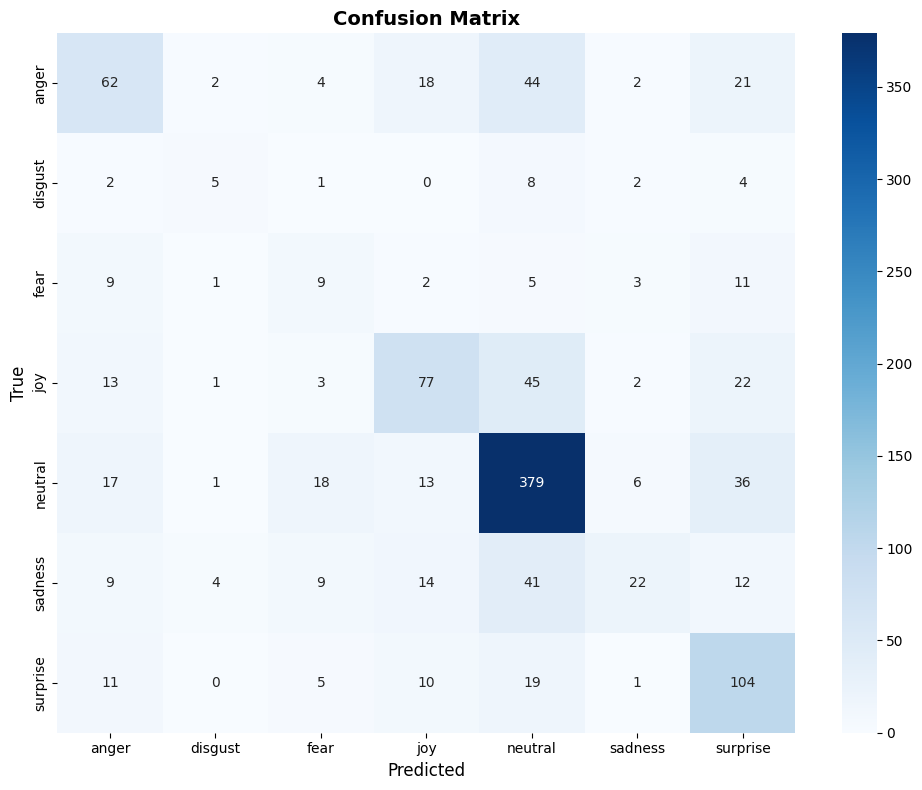

In [54]:
cm = confusion_matrix(dev_labels, dev_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_names, yticklabels=emotion_names)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.tight_layout()
plt.show()
plt.savefig(RESULTS_DIR / "confusion_matrix_exp_5.png", dpi=300)
plt.close()


### 1️5️ TRAINING CURVES

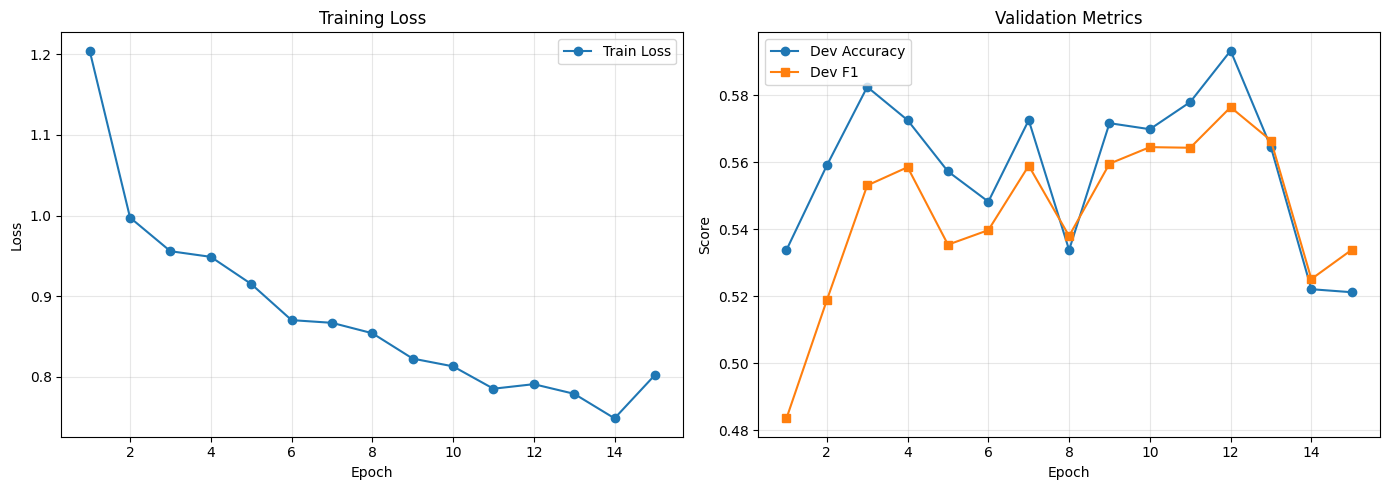

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
axes[0].plot(range(1, len(train_losses)+1), train_losses,
             marker='o', label='Train Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy and F1 curves
axes[1].plot(range(1, len(dev_accuracies)+1), dev_accuracies,
             marker='o', label='Dev Accuracy')
axes[1].plot(range(1, len(dev_f1_scores)+1), dev_f1_scores,
             marker='s', label='Dev F1')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Validation Metrics')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig(RESULTS_DIR / "training_curves_exp_5.png", dpi=300)
plt.close()


### 1️6️ SAVE RESULTS

In [56]:
best_epoch = int(np.argmax(dev_f1_scores))

In [57]:
results = {
    "final_accuracy": float(final_acc),
    "final_weighted_f1": float(final_f1),
    "f1_per_class": {
        emotion_names[i]: float(final_f1_per_class[i])
        for i in range(len(emotion_names))
    },
    "best_epoch": best_epoch,
    "training_config": {
        "epochs": EPOCHS,
        "batch_size": 128,
        "learning_rate": 5e-5,
        "Weight_decay" : 0.05,
        "optimizer": "AdamW",
        "loss": "Focal Loss"
    }
}
print(results)
with open(OUTPUT_DIR / "final_results_exp_4.json", "w") as f:
    json.dump(results, f, indent=2)

{'final_accuracy': 0.5933273219116321, 'final_weighted_f1': 0.5764541174920217, 'f1_per_class': {'anger': 0.4492753623188406, 'disgust': 0.2777777777777778, 'fear': 0.20224719101123595, 'joy': 0.5185185185185186, 'neutral': 0.7497527200791296, 'sadness': 0.2953020134228188, 'surprise': 0.5777777777777777}, 'best_epoch': 11, 'training_config': {'epochs': 15, 'batch_size': 128, 'learning_rate': 5e-05, 'Weight_decay': 0.05, 'optimizer': 'AdamW', 'loss': 'Focal Loss'}}


In [58]:
print(f"\n Results saved to: {OUTPUT_DIR}")
print(f"  - Model: {MODEL_DIR / 'best_model.pt'}")
print(f"  - Results: {OUTPUT_DIR / 'final_results_exp_4.json'}")
print(f"  - Plots: {RESULTS_DIR}")
print(f"  - TensorBoard logs: {LOG_DIR}")

print("\n Training complete! ")


 Results saved to: /kaggle/working/outputs
  - Model: /kaggle/working/outputs/models/best_model.pt
  - Results: /kaggle/working/outputs/final_results_exp_4.json
  - Plots: /kaggle/working/outputs/Results
  - TensorBoard logs: /kaggle/working/outputs/logs

 Training complete! 


## RESEARCH EXTENSIONS

### 1️7️ ABLATION STUDY - Test Unimodal & Bimodal Performance

In [87]:
class UnimodalFusion(nn.Module):
    def __init__(self, hidden_dim=768, num_classes=7):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, emb):
        return self.classifier(emb)

In [88]:
class BimodalFusion(nn.Module):
    def __init__(self, hidden_dim=768, num_classes=7):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, emb1, emb2):
        combined = torch.cat([emb1, emb2], dim=1)
        return self.classifier(combined)

In [89]:
def train_and_eval(model, emb1, labels, emb2=None, epochs=15, batch_size=64):
    if emb2 is None:
        embeddings = emb1
    else:
        embeddings = (emb1, emb2)

    # Create dataset
    class AblationDataset(Dataset):
        def __init__(self, e1, e2, labels):
            self.e1 = e1
            self.e2 = e2
            self.labels = labels
            self.bimodal = e2 is not None

        def __len__(self):
            return len(self.labels)

        def __getitem__(self, idx):
            if self.bimodal:
                return self.e1[idx], self.e2[idx], self.labels[idx]
            else:
                return self.e1[idx], self.labels[idx]

    dataset = AblationDataset(emb1, emb2, labels)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = AdamW(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    # TRAIN
    model.train()
    for _ in range(epochs):
        for batch in loader:
            optimizer.zero_grad()

            if emb2 is None:
                e, lab = batch
                e = e.to(DEVICE)
                lab = lab.to(DEVICE)
                logits = model(e)
            else:
                e1, e2, lab = batch
                logits = model(e1.to(DEVICE), e2.to(DEVICE))
                lab = lab.to(DEVICE)

            loss = criterion(logits, lab)
            loss.backward()
            optimizer.step()

    # EVAL
    model.eval()
    with torch.no_grad():
        if emb2 is None:
            logits = model(emb1)
        else:
            logits = model(emb1, emb2)

        preds = logits.argmax(1)

    acc = accuracy_score(labels.cpu(), preds.cpu())
    f1 = f1_score(labels.cpu(), preds.cpu(), average="weighted")

    return acc, f1


In [90]:
print("Collecting embeddings for ablation study...")

all_text_embs = []
all_audio_embs = []
all_video_embs = []
all_labels = []

for text, audio, video, labels, audio_mask in tqdm(dev_loader, desc="Extracting"):
    all_text_embs.append(text)
    all_audio_embs.append(audio)
    all_video_embs.append(video)
    all_labels.append(labels)

all_text_embs = torch.cat(all_text_embs).to(DEVICE)
all_audio_embs = torch.cat(all_audio_embs).to(DEVICE)
all_video_embs = torch.cat(all_video_embs).to(DEVICE)
all_labels = torch.cat(all_labels).to(DEVICE)

Extracting:   0%|          | 0/5 [00:00<?, ?it/s]

In [91]:
ablation_results = {}

In [92]:
print("\nTesting: TEXT")
model = UnimodalFusion().to(DEVICE)
acc, f1 = train_and_eval(model, all_text_embs, all_labels)
ablation_results["text"] = {
    "accuracy": float(acc),
    "f1": float(f1)
}
print(acc, f1)


Testing: TEXT
0.690712353471596 0.666239165474223


In [93]:
print("\nTesting: AUDIO")
model = UnimodalFusion().to(DEVICE)
acc, f1 = train_and_eval(model, all_audio_embs, all_labels)
ablation_results["audio"] = {
    "accuracy": float(acc),
    "f1": float(f1)
}
print(acc, f1)



Testing: AUDIO
0.4715960324616772 0.35667634526603537


In [94]:
print("\nTesting: VIDEO")
model = UnimodalFusion().to(DEVICE)
acc, f1 = train_and_eval(model, all_video_embs, all_labels)
ablation_results["video"] = {
    "accuracy": float(acc),
    "f1": float(f1)
}
print(acc, f1)



Testing: VIDEO
0.4238052299368801 0.2522969703234118


In [95]:
print("\nTesting: TEXT + AUDIO")
model = BimodalFusion().to(DEVICE)
acc, f1 = train_and_eval(model, all_text_embs, all_labels, emb2=all_audio_embs)
ablation_results["text+audio"] = {
    "accuracy": float(acc),
    "f1": float(f1)
}
print(acc, f1)



Testing: TEXT + AUDIO
0.7871956717763751 0.7765469159508193


In [96]:
print("\nTesting: TEXT + VIDEO")
model = BimodalFusion().to(DEVICE)
acc, f1 = train_and_eval(model, all_text_embs, all_labels, emb2=all_video_embs)
ablation_results["text+video"] = {
    "accuracy": float(acc),
    "f1": float(f1)
}
print(acc, f1)



Testing: TEXT + VIDEO
0.6212804328223624 0.5629086095182877


In [97]:
print("\nTesting: AUDIO + VIDEO")
model = BimodalFusion().to(DEVICE)
acc, f1 = train_and_eval(model, all_audio_embs, all_labels, emb2=all_video_embs)
ablation_results["audio+video"] = {
    "accuracy": float(acc),
    "f1": float(f1)
}
print(acc, f1)



Testing: AUDIO + VIDEO
0.4472497745716862 0.30508892749576866


In [98]:
ablation_results["text+audio+video"] = {
    "accuracy": float(final_acc),
    "f1": float(final_f1)
}
ablation_results

{'text': {'accuracy': 0.690712353471596, 'f1': 0.666239165474223},
 'audio': {'accuracy': 0.4715960324616772, 'f1': 0.35667634526603537},
 'video': {'accuracy': 0.4238052299368801, 'f1': 0.2522969703234118},
 'text+audio': {'accuracy': 0.7871956717763751, 'f1': 0.7765469159508193},
 'text+video': {'accuracy': 0.6212804328223624, 'f1': 0.5629086095182877},
 'audio+video': {'accuracy': 0.4472497745716862, 'f1': 0.30508892749576866},
 'text+audio+video': {'accuracy': 0.5933273219116321,
  'f1': 0.5764541174920217}}

In [99]:
with open(RESULTS_DIR / "ablation_results1.json", "w") as f:
    json.dump(ablation_results, f, indent=2)

print("\nAblation study completed!")


Ablation study completed!


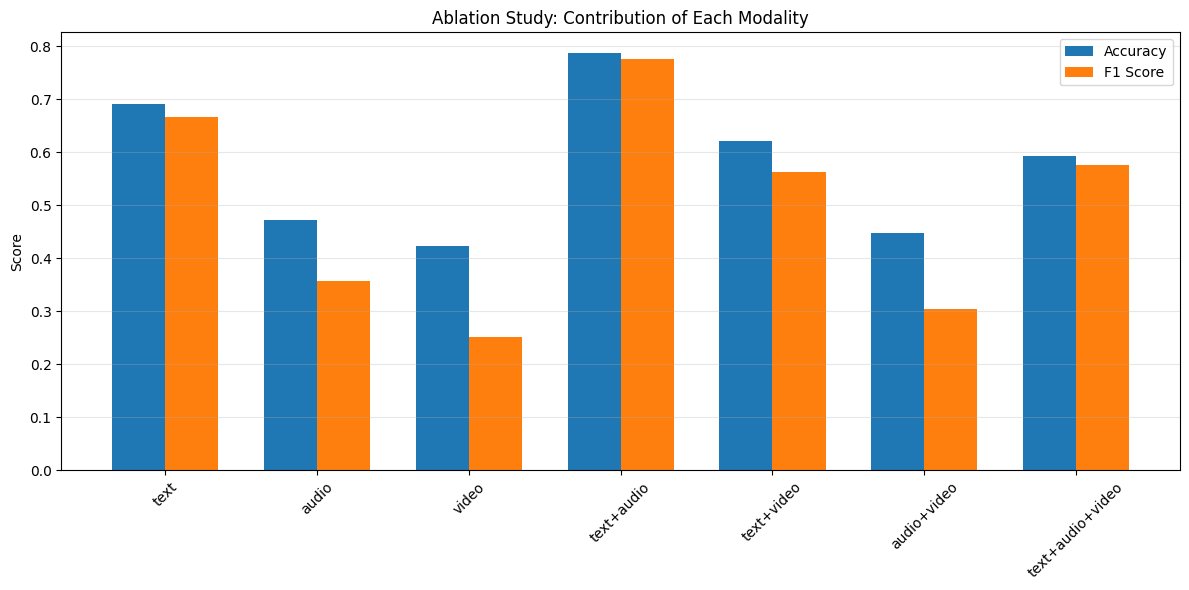

In [100]:
fig, ax = plt.subplots(figsize=(12, 6))

combos = list(ablation_results.keys())
accs = [ablation_results[c]["accuracy"] for c in combos]
f1s  = [ablation_results[c]["f1"] for c in combos]

x = np.arange(len(combos))
w = 0.35

ax.bar(x - w/2, accs, w, label="Accuracy")
ax.bar(x + w/2, f1s, w, label="F1 Score")

ax.set_xticks(x)
ax.set_xticklabels(combos, rotation=45)
ax.set_title("Ablation Study: Contribution of Each Modality")
ax.set_ylabel("Score")
ax.legend()
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig(RESULTS_DIR / "ablation_study1.png", dpi=300)
plt.close()


In [85]:
with open(RESULTS_DIR / "ablation_results1.json", "w") as f:
    json.dump(ablation_results, f, indent=2)


### 1️8️ ATTENTION VISUALIZATION

In [101]:
class AttentionAnalyzer:
    def __init__(self, model):
        self.model = model
        self.attention_weights = None

        def hook_fn(module, input, output):
            # output is (attn_output, attn_weights)
            self.attention_weights = output[1]  

        # attach hook to cross-attention layer
        self.model.cross_attention.register_forward_hook(hook_fn)

    def get_attention(self, text, audio, video, audio_mask=None):
        self.model.eval()
        with torch.no_grad():
            _ = self.model(text, audio, video, audio_mask)
        return self.attention_weights


analyzer = AttentionAnalyzer(fusion_model)

In [102]:
sample_batch = next(iter(dev_loader))
text_emb  = sample_batch[0].to(DEVICE)
audio_emb = sample_batch[1].to(DEVICE)
video_emb = sample_batch[2].to(DEVICE)
audio_mask = sample_batch[4].to(DEVICE)

In [103]:
# take first 4 samples
attn_weights = analyzer.get_attention(
    text_emb[:4], audio_emb[:4], video_emb[:4], audio_mask[:4]
)

In [104]:
attn_avg = attn_weights.mean(dim=0).mean(dim=0).cpu().numpy()


In [105]:
print("attn_weights shape:", attn_weights.shape)
print("attn_avg shape:", attn_avg.shape)
print(attn_avg)


attn_weights shape: torch.Size([4, 6, 3, 3])
attn_avg shape: (3, 3)
[[0.6342399  0.34264383 0.02311626]
 [0.6500827  0.337582   0.0123354 ]
 [0.73449457 0.26373047 0.00177499]]


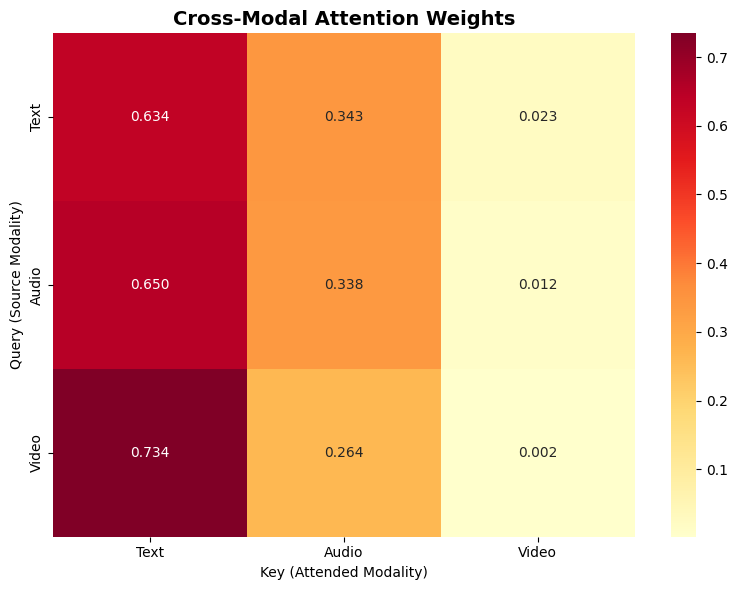

Attention visualization saved!


In [106]:
modality_names = ['Text', 'Audio', 'Video']

plt.figure(figsize=(8, 6))
sns.heatmap(
    attn_avg,
    annot=True,
    fmt=".3f",
    cmap="YlOrRd",
    xticklabels=modality_names,
    yticklabels=modality_names
)
plt.title("Cross-Modal Attention Weights", fontsize=14, fontweight="bold")
plt.xlabel("Key (Attended Modality)")
plt.ylabel("Query (Source Modality)")
plt.tight_layout()
plt.show()
plt.savefig(RESULTS_DIR / "attention_visualization.png", dpi=300)
plt.close()

print("Attention visualization saved!")


### 1️9️ ERROR ANALYSIS - Analyze Misclassifications

In [107]:
print("\n\nRESEARCH EXTENSION 3: Error Analysis")



RESEARCH EXTENSION 3: Error Analysis


In [108]:
# Get misclassified samples
misclassified_indices = [i for i, (pred, true) in enumerate(
    zip(dev_preds, dev_labels)) if pred != true]
print(f"Found {len(misclassified_indices)} misclassified samples")

Found 451 misclassified samples


In [109]:
# Analyze error patterns
error_analysis = {
    "total_errors": len(misclassified_indices),
    "error_rate": len(misclassified_indices) / len(dev_labels),
    "confusion_pairs": {}
}

In [110]:
for idx in misclassified_indices:
    true_label = emotion_names[int(dev_labels[idx])]
    pred_label = emotion_names[int(dev_preds[idx])]

    pair = f"{true_label} → {pred_label}"
    error_analysis["confusion_pairs"][pair] = error_analysis["confusion_pairs"].get(
        pair, 0) + 1

In [111]:
# Sort by frequency
sorted_errors = sorted(
    error_analysis["confusion_pairs"].items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 confusion pairs:")
for pair, count in sorted_errors[:10]:
    print(f"  {pair}: {count} occurrences")


Top 10 confusion pairs:
  joy → neutral: 45 occurrences
  anger → neutral: 44 occurrences
  sadness → neutral: 41 occurrences
  neutral → surprise: 36 occurrences
  joy → surprise: 22 occurrences
  anger → surprise: 21 occurrences
  surprise → neutral: 19 occurrences
  neutral → fear: 18 occurrences
  anger → joy: 18 occurrences
  neutral → anger: 17 occurrences


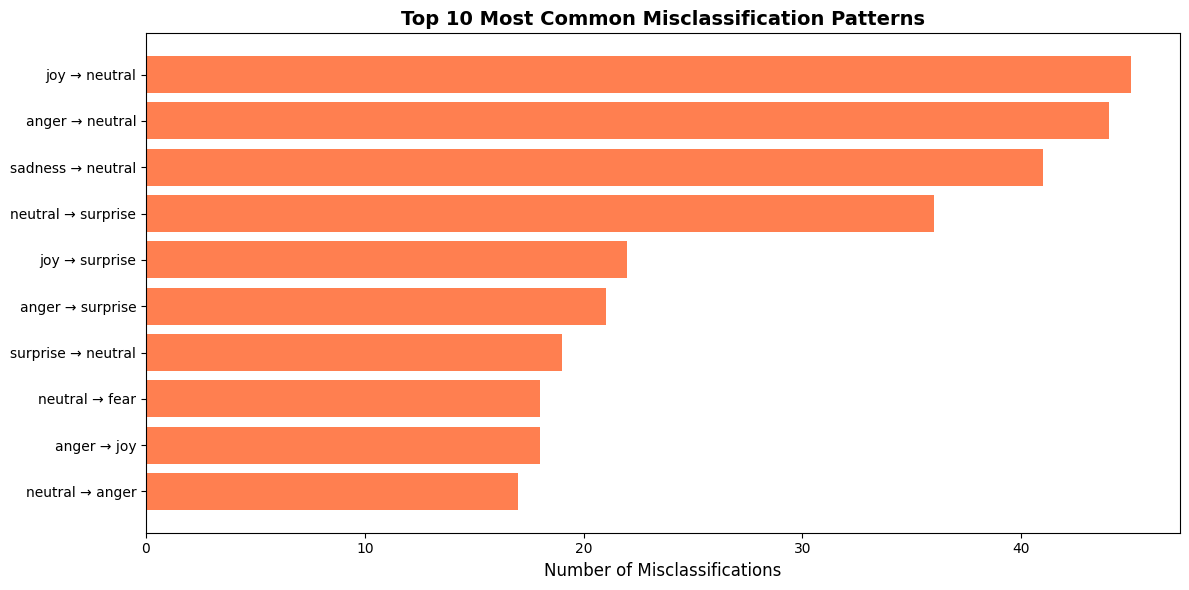

In [112]:
# Visualize most common errors
top_n = 10
pairs, counts = zip(*sorted_errors[:top_n])

plt.figure(figsize=(12, 6))
plt.barh(range(len(pairs)), counts, color='coral')
plt.yticks(range(len(pairs)), pairs)
plt.xlabel('Number of Misclassifications', fontsize=12)
plt.title('Top 10 Most Common Misclassification Patterns',
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
plt.savefig(RESULTS_DIR / "error_analysis.png", dpi=300)
plt.close()


In [113]:
# Save detailed error analysis
with open(RESULTS_DIR / "error_analysis.json", "w") as f:
    json.dump(error_analysis, f, indent=2)

print("Error analysis complete!")

Error analysis complete!


### 2️0️ FEATURE IMPORTANCE via Gradient-based Attribution

In [114]:
def compute_gradient_importance(model, text_emb, audio_emb, video_emb, label):
    """Compute gradient-based importance for each modality"""
    model.eval()
    
    # Reset gradients before backprop
    model.zero_grad()

    text_emb = text_emb.clone().requires_grad_(True)
    audio_emb = audio_emb.clone().requires_grad_(True)
    video_emb = video_emb.clone().requires_grad_(True)

    logits = model(text_emb, audio_emb, video_emb)
    loss = criterion(logits, label)

    loss.backward()

    text_importance = text_emb.grad.abs().sum().item()
    audio_importance = audio_emb.grad.abs().sum().item()
    video_importance = video_emb.grad.abs().sum().item()

    total = text_importance + audio_importance + video_importance

    return {
        'text': text_importance / total,
        'audio': audio_importance / total,
        'video': video_importance / total
    }

In [115]:
def get_embeddings(batch):
    return batch["text"], batch["audio"], batch["video"]


In [116]:
# Compute for each emotion class
importance_by_emotion = {
    emotion: {'text': [], 'audio': [], 'video': []} for emotion in emotion_names}

In [117]:
print("Computing feature importance per emotion...")
fusion_model.eval()

sample_count = 50  # Samples per emotion
for emotion_idx, emotion in enumerate(emotion_names):
    count = 0
    for batch in dev_loader:
        if count >= sample_count:
            break

        # Unpack batch (because DataLoader returns tuple, not dict)
        text_b, audio_b, video_b, labels_b, audio_mask_b = batch

        # Move to device
        text_b = text_b.to(DEVICE)
        audio_b = audio_b.to(DEVICE)
        video_b = video_b.to(DEVICE)
        labels_b = labels_b.to(DEVICE)

        # Find samples of this emotion
        emotion_mask = labels_b == emotion_idx
        if not emotion_mask.any():
            continue

        # Embeddings are already precomputed → use them directly
        text_emb  = text_b
        audio_emb = audio_b
        video_emb = video_b

        # Compute importance for each sample of this emotion
        for i in torch.where(emotion_mask)[0]:
            if count >= sample_count:
                break

            importance = compute_gradient_importance(
                fusion_model,
                text_emb[i:i+1],
                audio_emb[i:i+1],
                video_emb[i:i+1],
                labels_b[i:i+1]
            )

            importance_by_emotion[emotion]['text'].append(importance['text'])
            importance_by_emotion[emotion]['audio'].append(importance['audio'])
            importance_by_emotion[emotion]['video'].append(importance['video'])
            count += 1


Computing feature importance per emotion...


In [118]:
# Average importance per emotion
avg_importance = {
    emotion: {
        'text': np.mean(vals['text']),
        'audio': np.mean(vals['audio']),
        'video': np.mean(vals['video'])
    }
    for emotion, vals in importance_by_emotion.items()
}

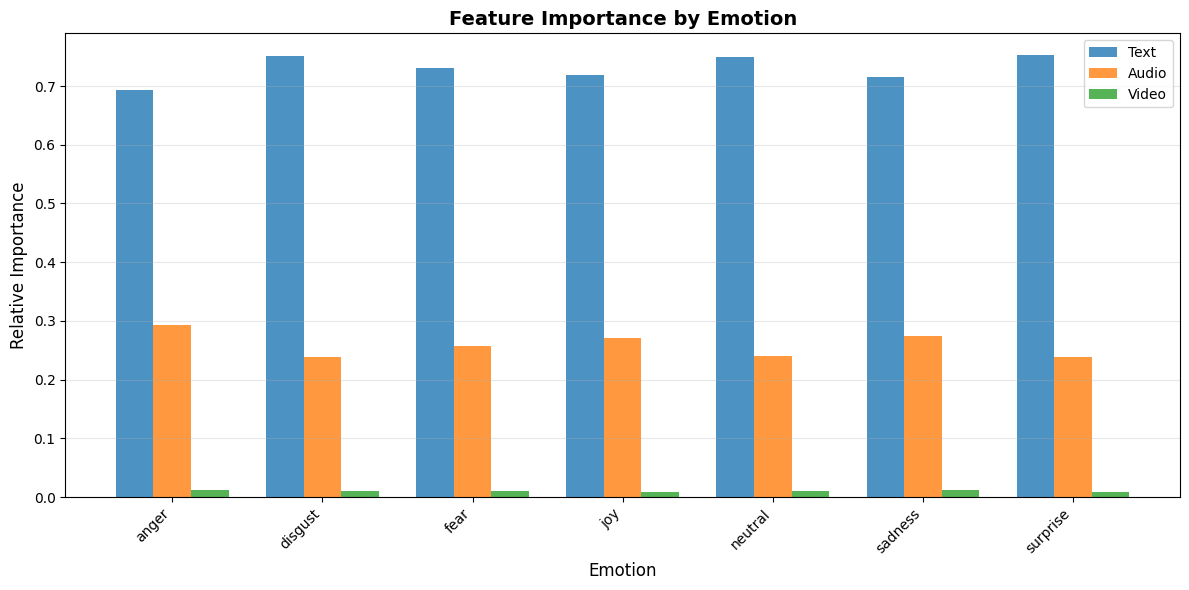

In [119]:
# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(emotion_names))
width = 0.25

text_vals = [avg_importance[e]['text'] for e in emotion_names]
audio_vals = [avg_importance[e]['audio'] for e in emotion_names]
video_vals = [avg_importance[e]['video'] for e in emotion_names]

ax.bar(x - width, text_vals, width, label='Text', alpha=0.8)
ax.bar(x, audio_vals, width, label='Audio', alpha=0.8)
ax.bar(x + width, video_vals, width, label='Video', alpha=0.8)

ax.set_xlabel('Emotion', fontsize=12)
ax.set_ylabel('Relative Importance', fontsize=12)
ax.set_title('Feature Importance by Emotion', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(emotion_names, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()
plt.savefig(RESULTS_DIR / "feature_importance.png", dpi=300)
plt.close()

In [120]:
# Save results
with open(RESULTS_DIR / "feature_importance.json", "w") as f:
    json.dump(avg_importance, f, indent=2)

print("Feature importance analysis complete!")

Feature importance analysis complete!


### 2️1️ STATISTICAL SIGNIFICANCE TESTING

In [121]:
# Bootstrap confidence intervals

def bootstrap_ci(y_true, y_pred, metric_fn, n_bootstrap=1000, confidence=0.95):
    """Compute bootstrap confidence interval"""
    np.random.seed(42)
    scores = []

    for _ in range(n_bootstrap):
        indices = np.random.choice(len(y_true), len(y_true), replace=True)
        score = metric_fn(
            [y_true[i] for i in indices],
            [y_pred[i] for i in indices]
        )
        scores.append(score)

    alpha = (1 - confidence) / 2
    lower = np.percentile(scores, alpha * 100)
    upper = np.percentile(scores, (1 - alpha) * 100)

    return lower, upper, scores

In [122]:
# Compute CI for accuracy
acc_lower, acc_upper, acc_scores = bootstrap_ci(
    dev_labels, dev_preds,
    lambda y_true, y_pred: accuracy_score(y_true, y_pred)
)

In [123]:
# Compute CI for F1
f1_lower, f1_upper, f1_scores = bootstrap_ci(
    dev_labels, dev_preds,
    lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted')
)

In [124]:
print(
    f"Accuracy: {final_acc:.4f} (95% CI: [{acc_lower:.4f}, {acc_upper:.4f}])")
print(f"F1 Score: {final_f1:.4f} (95% CI: [{f1_lower:.4f}, {f1_upper:.4f}])")

Accuracy: 0.5933 (95% CI: [0.5644, 0.6204])
F1 Score: 0.5765 (95% CI: [0.5459, 0.6047])


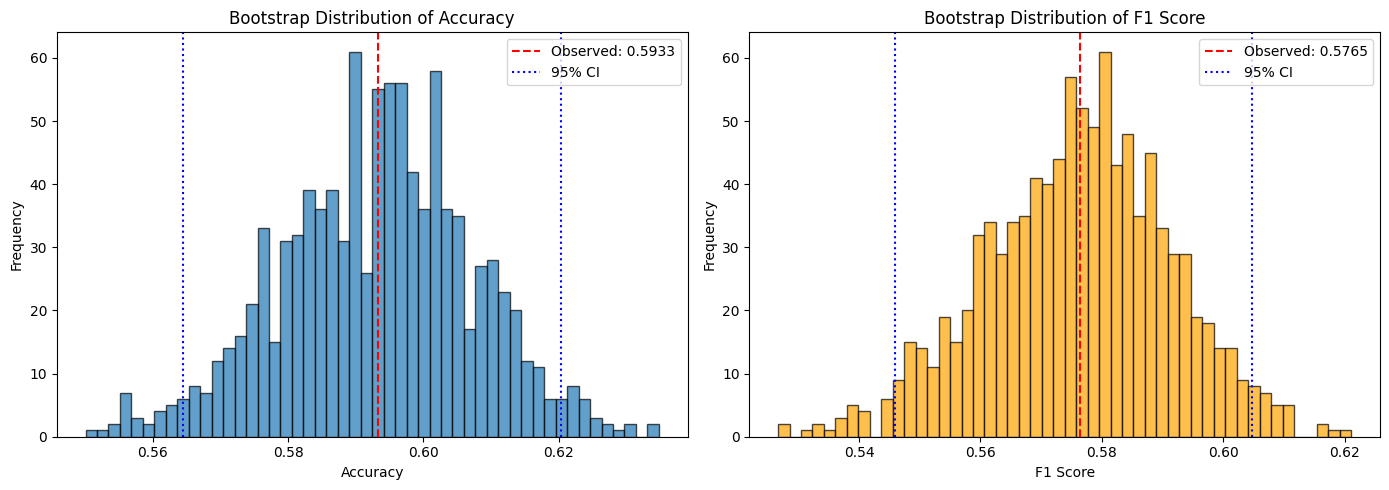

In [125]:
# Visualize distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(acc_scores, bins=50, alpha=0.7, edgecolor='black')
axes[0].axvline(final_acc, color='red', linestyle='--',
                label=f'Observed: {final_acc:.4f}')
axes[0].axvline(acc_lower, color='blue', linestyle=':', label=f'95% CI')
axes[0].axvline(acc_upper, color='blue', linestyle=':')
axes[0].set_xlabel('Accuracy')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Bootstrap Distribution of Accuracy')
axes[0].legend()

axes[1].hist(f1_scores, bins=50, alpha=0.7, edgecolor='black', color='orange')
axes[1].axvline(final_f1, color='red', linestyle='--',
                label=f'Observed: {final_f1:.4f}')
axes[1].axvline(f1_lower, color='blue', linestyle=':', label=f'95% CI')
axes[1].axvline(f1_upper, color='blue', linestyle=':')
axes[1].set_xlabel('F1 Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Bootstrap Distribution of F1 Score')
axes[1].legend()

plt.tight_layout()
plt.show()
plt.savefig(RESULTS_DIR / "statistical_significance.png", dpi=300)
plt.close()

In [126]:
statistical_results = {
    "accuracy": {
        "value": float(final_acc),
        "ci_lower": float(acc_lower),
        "ci_upper": float(acc_upper)
    },
    "f1_score": {
        "value": float(final_f1),
        "ci_lower": float(f1_lower),
        "ci_upper": float(f1_upper)
    }
}

with open(RESULTS_DIR / "statistical_significance.json", "w") as f:
    json.dump(statistical_results, f, indent=2)

print("Statistical significance testing complete!")

Statistical significance testing complete!


### 2️2️ GENERATE RESEARCH PAPER READY TABLES

In [127]:
print("\n\nRESEARCH EXTENSION 6: Publication-Ready Tables")



RESEARCH EXTENSION 6: Publication-Ready Tables


In [128]:
# Table 1: Main Results
print("\nTable 1: Main Results")
print("-" * 60)
print(f"{'Model':<30} {'Accuracy':<12} {'F1 Score':<12}")
print("-" * 60)
print(f"{'Multimodal (Ours)':<30} {final_acc:.4f}       {final_f1:.4f}")
print("-" * 60)


Table 1: Main Results
------------------------------------------------------------
Model                          Accuracy     F1 Score    
------------------------------------------------------------
Multimodal (Ours)              0.5933       0.5765
------------------------------------------------------------


In [129]:
# Table 2: Ablation Study
print("\nTable 2: Ablation Study")
print("-" * 60)
print(f"{'Modalities':<30} {'Accuracy':<12} {'F1 Score':<12} {'Δ from Full':<12}")
print("-" * 60)
full_f1 = ablation_results["text+audio+video"]["f1"]
for combo in ["text", "audio", "video", "text+audio", "text+video", "audio+video", "text+audio+video"]:
    res = ablation_results[combo]
    delta = res["f1"] - full_f1
    print(
        f"{combo:<30} {res['accuracy']:.4f}       {res['f1']:.4f}       {delta:+.4f}")
print("-" * 60)


Table 2: Ablation Study
------------------------------------------------------------
Modalities                     Accuracy     F1 Score     Δ from Full 
------------------------------------------------------------
text                           0.6907       0.6662       +0.0898
audio                          0.4716       0.3567       -0.2198
video                          0.4238       0.2523       -0.3242
text+audio                     0.7872       0.7765       +0.2001
text+video                     0.6213       0.5629       -0.0135
audio+video                    0.4472       0.3051       -0.2714
text+audio+video               0.5933       0.5765       +0.0000
------------------------------------------------------------


In [131]:
# Save LaTeX tables
latex_content = f"""
% Table 1: Main Results
\\begin{{table}}[h]
\\centering
\\caption{{Overall Performance on MELD Dataset}}
\\begin{{tabular}}{{lcc}}
\\hline
Model & Accuracy & F1 Score \\\\
\\hline
Multimodal (Ours) & {final_acc:.4f} & {final_f1:.4f} \\\\
\\hline
\\end{{tabular}}
\\end{{table}}

% Table 2: Ablation Study
\\begin{{table}}[h]
\\centering
\\caption{{Ablation Study Results}}
\\begin{{tabular}}{{lccc}}
\\hline
Modalities & Accuracy & F1 Score & $\\Delta$ from Full \\\\
\\hline
"""

In [132]:
for combo in ["text", "audio", "video", "text+audio", "text+video", "audio+video", "text+audio+video"]:
    res = ablation_results[combo]
    delta = res["f1"] - full_f1
    latex_content += f"{combo} & {res['accuracy']:.4f} & {res['f1']:.4f} & {delta:+.4f} \\\\\n"

In [133]:
latex_content += """\\hline
\\end{tabular}
\\end{table}

% Table 3: Per-Class Performance
\\begin{table}[h]
\\centering
\\caption{Per-Class Performance Metrics}
\\begin{tabular}{lcccc}
\\hline
Emotion & Precision & Recall & F1-Score & Support \\\\
\\hline
"""

In [135]:
latex_content += """\\hline
\\end{tabular}
\\end{table}
"""

In [136]:
with open(RESULTS_DIR / "latex_tables.tex", "w") as f:
    f.write(latex_content)

print("\nLaTeX tables saved to latex_tables.tex")


LaTeX tables saved to latex_tables.tex


### 2️3️ GENERATE COMPREHENSIVE RESEARCH REPORT

In [ ]:
print("\n\nGenerating Comprehensive Research Report...")

In [ ]:
with open(RESULTS_DIR / "research_report.md", "w") as f:
    f.write(report_content)

print("Comprehensive research report saved!")

### FINAL SUMMARY

##  ADVANCED RESEARCH EXTENSIONS

### 2️4️ TEMPORAL VIDEO MODELING

In [41]:
def extract_frames_uniform(mp4_path, num_frames=8):
    """Extract num_frames uniformly sampled frames from video."""
    try:
        frames, _, _ = tvio.read_video(str(mp4_path), pts_unit="sec")

        if len(frames) == 0:
            # return 8 blank frames
            blank = torch.zeros((224, 224, 3), dtype=torch.uint8)
            return [blank] * num_frames

        # Uniform sampling
        indices = np.linspace(0, len(frames) - 1, num_frames, dtype=int)
        sampled = [frames[i] for i in indices]
        return sampled

    except Exception:
        blank = torch.zeros((224, 224, 3), dtype=torch.uint8)
        return [blank] * num_frames


In [43]:
def compute_temporal_embeddings(df, split, num_frames=8):
    """Compute text, audio, and MULTI-FRAME video embeddings."""
    
    save_path = EMB_DIR / f"{split}_temporal_embeddings.pt"
    if save_path.exists():
        print(f"{split} embeddings already exist, skipping.")
        return

    all_text, all_audio, all_video, all_labels, all_mask = [], [], [], [], []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Embedding {split}"):

        fname = f"dia{int(row['Dialogue_ID'])}_utt{int(row['Utterance_ID'])}"

        # ---------------- TEXT ----------------
        text = str(row["Utterance"])
        tok = bert_tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding="max_length",
            max_length=64
        ).to(DEVICE)

        with torch.no_grad():
            text_emb = bert_model(**tok).last_hidden_state[:, 0]   # CLS token

        # ---------------- AUDIO ----------------
        wav_path = audio_dirs[split] / f"{fname}.wav"
        if wav_path.exists():
            waveform, sr = torchaudio.load(wav_path)
            if sr != 16000:
                waveform = torchaudio.transforms.Resample(sr, 16000)(waveform)
            waveform = waveform.mean(0).numpy()
            audio_mask = is_silent_audio(waveform)
        else:
            waveform = np.zeros(16000 * 2)
            audio_mask = True

        audio_input = wav_extractor(
            waveform,
            sampling_rate=16000,
            return_tensors="pt",
            padding=True
        ).to(DEVICE)

        with torch.no_grad():
            audio_emb = wav2vec_model(**audio_input).last_hidden_state.mean(1)

        # ---------------- VIDEO (MULTI-FRAME) ----------------
        mp4_path = split_dirs[split] / f"{fname}.mp4"
        frames = extract_frames_uniform(mp4_path, num_frames=num_frames)
        
        frame_embs = []
        with torch.no_grad():
            for f in frames:
                f_np = f.numpy()
                vinput = vit_processor(images=f_np, return_tensors="pt").to(DEVICE)
                v_emb = vit_model(**vinput).last_hidden_state[:, 0]  # CLS embedding
                frame_embs.append(v_emb.cpu())

        # Convert list → (num_frames, 768)
        frame_embs = torch.cat(frame_embs, dim=0)   # shape: (num_frames, 768)

        # ---------------- LABEL ----------------
        label_map = {
            "anger": 0, "disgust": 1, "fear": 2, 
            "joy": 3, "neutral": 4, "sadness": 5, "surprise": 6
        }
        label = label_map.get(row["Emotion"], 4)

        # ---------------- STORE ----------------
        all_text.append(text_emb.cpu())
        all_audio.append(audio_emb.cpu())
        all_video.append(frame_embs.unsqueeze(0))     # shape (1, F, 768)
        all_labels.append(torch.tensor(label))
        all_mask.append(torch.tensor(audio_mask))

        del text_emb, audio_emb, frame_embs
        gc.collect()

    # --------- SAVE OUTPUT ----------
    torch.save({
        "text": torch.cat(all_text),                      # (N, 768)
        "audio": torch.cat(all_audio),                    # (N, 768)
        "video": torch.cat(all_video),                    # (N, F, 768)
        "labels": torch.stack(all_labels),                # (N,)
        "audio_mask": torch.stack(all_mask)               # (N,)
    }, save_path)

    print(f"Saved {split} embeddings → {save_path}")


In [47]:
compute_temporal_embeddings(train_df, "train")
compute_temporal_embeddings(dev_df, "dev")

Embedding train:   0%|          | 0/9989 [00:00<?, ?it/s]

Saved train embeddings → /kaggle/working/outputs/embeddings/train_temporal_embeddings.pt


Embedding dev:   0%|          | 0/1109 [00:00<?, ?it/s]

Saved dev embeddings → /kaggle/working/outputs/embeddings/dev_temporal_embeddings.pt


In [169]:
TRAIN_EMB = EMB_DIR / "train_temporal_embeddings.pt"
DEV_EMB = EMB_DIR / "dev_temporal_embeddings.pt"


HIDDEN_DIM = 768
NUM_FRAMES = 8            # number of frames the temporal encoder expects
BATCH_SIZE = 64
EPOCHS = 15
LR = 5e-5
NUM_WORKERS = 0   


BASELINE_F1 = globals().get("final_f1", None)

In [172]:
def load_embeddings(path: Path):
    """Load an embeddings file saved as a dict with keys: text, audio, video, labels, (optional) audio_mask"""
    d = torch.load(path, map_location="cpu")
    # Expect keys: "text","audio","video","labels" (as saved by earlier script)
    return d

In [174]:
def ensure_video_frames(video_tensor, desired_frames=NUM_FRAMES):
    """
    Accept video_tensor shape either:
     - (N, H)  -> single-vector per sample, replicate to (N, desired_frames, H)
     - (N, F, H) -> already multi-frame (F may differ from desired_frames -> pad/trim)
    """
    if video_tensor.ndim == 2:
        # replicate vector across frames
        N, H = video_tensor.shape
        out = video_tensor.unsqueeze(1).repeat(1, desired_frames, 1)
        return out  # (N, desired_frames, H)
    elif video_tensor.ndim == 3:
        N, F, H = video_tensor.shape
        if F == desired_frames:
            return video_tensor
        elif F > desired_frames:
            return video_tensor[:, :desired_frames, :]
        else:
            # pad last frames with zeros
            pad = torch.zeros((N, desired_frames - F, H), dtype=video_tensor.dtype)
            return torch.cat([video_tensor, pad], dim=1)
    else:
        raise ValueError("Unexpected video tensor dims: ", video_tensor.shape)

In [170]:
class TemporalEmbeddingDataset(Dataset):
    def __init__(self, emb_path: Path, num_frames=NUM_FRAMES, device=torch.device("cpu")):
        data = load_embeddings(emb_path)
        # Expect data["text"] shape (N, hidden), etc.
        self.text = data["text"]  # Tensor on CPU
        self.audio = data["audio"]
        self.video = data["video"]
        self.labels = data["labels"].long()
        self.audio_mask = data.get("audio_mask", None)
        # Ensure consistent video shape (N, num_frames, hidden)
        self.video = ensure_video_frames(self.video, desired_frames=num_frames)
        self.num_frames = num_frames

        # If they are CPU tensors, keep that and move to device in DataLoader loop
        assert len(self.text) == len(self.labels)
        self.n = len(self.labels)

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        # return raw tensors (CPU) — DataLoader loop will move to device
        item = {
            "text": self.text[idx],
            "audio": self.audio[idx],
            "video_frames": self.video[idx],  # shape (num_frames, hidden)
            "label": self.labels[idx]
        }
        if self.audio_mask is not None:
            item["audio_mask"] = self.audio_mask[idx]
        return item

In [177]:
def collate_fn(batch):
    # stack per-key
    text = torch.stack([b["text"] for b in batch], dim=0)
    audio = torch.stack([b["audio"] for b in batch], dim=0)
    video = torch.stack([b["video_frames"] for b in batch], dim=0)
    labels = torch.stack([b["label"] for b in batch], dim=0)
    audio_mask = None
    if "audio_mask" in batch[0]:
        audio_mask = torch.stack([b["audio_mask"] for b in batch], dim=0)
    out = {
        "text": text,
        "audio": audio,
        "video_frames": video,
        "labels": labels
    }
    if audio_mask is not None:
        out["audio_mask"] = audio_mask
    return out

In [66]:
class TemporalVideoEncoder(nn.Module):
    """LSTM over multiple video frames for temporal dynamics"""
    def __init__(self, hidden_dim=HIDDEN_DIM, num_frames=NUM_FRAMES):
        super().__init__()
        self.num_frames = num_frames
        # bidirectional LSTM -> output dim hidden_dim*2
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=1,
                           batch_first=True, bidirectional=True)
        # attention over frames (heads must fit embed dim)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim*2, num_heads=8, batch_first=True)
        self.fc = nn.Linear(hidden_dim*2, hidden_dim)
        self.layer_norm = nn.LayerNorm(hidden_dim)

    def forward(self, frame_embeddings):
        # frame_embeddings: [batch, num_frames, hidden_dim]
        lstm_out, _ = self.lstm(frame_embeddings)  # -> (batch, num_frames, hidden_dim*2)
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out, need_weights=False, average_attn_weights=True)
        pooled = attn_out.mean(dim=1)  # (batch, hidden_dim*2)
        out = self.fc(pooled)  # (batch, hidden_dim)
        return self.layer_norm(out)  # (batch, hidden_dim)


In [67]:
class TemporalFusionModel(nn.Module):
    """Fusion model with temporal video encoding"""
    def __init__(self, hidden_dim=HIDDEN_DIM, num_classes=7, dropout=0.3):
        super().__init__()
        self.proj_text = nn.Linear(hidden_dim, hidden_dim)
        self.proj_audio = nn.Linear(hidden_dim, hidden_dim)
        self.temporal_video = TemporalVideoEncoder(hidden_dim)
        # cross-attention expects embed_dim=hidden_dim and returns (batch, 3, hidden_dim)
        self.cross_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=8, dropout=dropout, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 3, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, text_emb, audio_emb, video_frames_emb, audio_mask=None):
        # Inputs shapes:
        # text_emb: (batch, hidden)
        # audio_emb: (batch, hidden)
        # video_frames_emb: (batch, num_frames, hidden)
        text_proj = self.proj_text(text_emb)
        audio_proj = self.proj_audio(audio_emb)
        video_proj = self.temporal_video(video_frames_emb)  # (batch, hidden)

        # optional audio masking: audio_mask shape (batch,) boolean -> zero out audio
        if audio_mask is not None:
            mask = audio_mask.unsqueeze(1).float()
            audio_proj = audio_proj * (1.0 - mask)

        multimodal = torch.stack([text_proj, audio_proj, video_proj], dim=1)  # (batch, 3, hidden)
        attn_out, _ = self.cross_attention(multimodal, multimodal, multimodal, need_weights=False, average_attn_weights=True)
        attn_out = self.layer_norm(attn_out)  # (batch,3,hidden)
        fused = attn_out.flatten(1)  # (batch, 3*hidden)
        logits = self.classifier(fused)
        return logits

In [175]:
print("Loading precomputed embeddings...")
# if not TRAIN_EMB.exists() or not DEV_EMB.exists():
#     raise RuntimeError(f"Embedding files not found. Expected: {TRAIN_EMB} and {DEV_EMB}")

train_ds = TemporalEmbeddingDataset("/kaggle/input/temporal-embeddings/temporal_embeddings/train_temporal_embeddings.pt", num_frames=NUM_FRAMES)
dev_ds = TemporalEmbeddingDataset("/kaggle/input/temporal-embeddings/temporal_embeddings/dev_temporal_embeddings.pt", num_frames=NUM_FRAMES)

print(f"Train samples: {len(train_ds)}, Dev samples: {len(dev_ds)}")

Loading precomputed embeddings...
Train samples: 9989, Dev samples: 1109


In [178]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn,
                          num_workers=NUM_WORKERS, pin_memory=True)
dev_loader = DataLoader(dev_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn,
                        num_workers=NUM_WORKERS, pin_memory=True)

In [179]:
# compute class weights if needed
train_labels_all = train_ds.labels.numpy()
class_counts = np.bincount(train_labels_all)
num_classes = int(train_ds.labels.max().item()) + 1
print("Train label counts:", class_counts)
class_weights = torch.tensor(
    (class_counts.sum() / (class_counts + 1e-12)) / class_counts.sum(), dtype=torch.float
)
# fallback normalization
class_weights = (1.0 / (class_counts + 1e-12))
class_weights = class_weights / class_weights.sum()
class_weights = torch.from_numpy(class_weights.astype(np.float32)).to(DEVICE)

Train label counts: [1109  271  268 1743 4710  683 1205]


In [71]:
fusion_model = TemporalFusionModel(hidden_dim=HIDDEN_DIM, num_classes=num_classes, dropout=0.3).to(DEVICE)
optimizer = AdamW(fusion_model.parameters(), lr=LR, weight_decay=0.01)
criterion = nn.CrossEntropyLoss(weight=class_weights)  # use class weights to reduce neutral bias
scaler = GradScaler()

print("Model parameters:", sum(p.numel() for p in fusion_model.parameters()))

Model parameters: 24933127


In [72]:
best_f1 = -1.0
history = {"train_loss": [], "dev_f1": [], "dev_acc": []}

for epoch in range(EPOCHS):
    fusion_model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch in pbar:

        text = batch["text"].to(DEVICE)
        audio = batch["audio"].to(DEVICE)
        video = batch["video_frames"].to(DEVICE)
        labels = batch["labels"].long().to(DEVICE)
        audio_mask = batch.get("audio_mask", None)
        if audio_mask is not None:
            audio_mask = audio_mask.to(DEVICE)

        optimizer.zero_grad(set_to_none=True)

        with autocast():
            logits = fusion_model(text, audio, video, audio_mask=audio_mask)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        preds = logits.argmax(dim=1)

        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

        # free
        del text, audio, video, labels, logits, preds

    # IMPORTANT FIX
    epoch_loss = running_loss / len(train_loader)
    history["train_loss"].append(epoch_loss)

    # -------------------------
    # Validation
    # -------------------------
    fusion_model.eval()
    dev_preds, dev_labels = [], []

    with torch.no_grad():
        for batch in dev_loader:
            text = batch["text"].to(DEVICE)
            audio = batch["audio"].to(DEVICE)
            video = batch["video_frames"].to(DEVICE)
            labels = batch["labels"].long().to(DEVICE)
            audio_mask = batch.get("audio_mask", None)
            if audio_mask is not None:
                audio_mask = audio_mask.to(DEVICE)

            with autocast():
                logits = fusion_model(text, audio, video, audio_mask=audio_mask)

            preds = logits.argmax(dim=1)

            dev_preds.extend(preds.cpu().tolist())
            dev_labels.extend(labels.cpu().tolist())

            del text, audio, video, labels, logits

    dev_acc = accuracy_score(dev_labels, dev_preds)
    dev_f1 = f1_score(dev_labels, dev_preds, average="weighted")

    history["dev_acc"].append(dev_acc)
    history["dev_f1"].append(dev_f1)

    print(f"\nEpoch {epoch+1} summary: Train Loss={epoch_loss:.4f} | Dev Acc={dev_acc:.4f} | Dev F1={dev_f1:.4f}")

    # -------------------------
    # Save best checkpoint
    # -------------------------
    if dev_f1 > best_f1:
        best_f1 = dev_f1
        torch.save({
            "epoch": epoch,
            "model_state_dict": fusion_model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "best_f1": best_f1
        }, MODEL_DIR / "temporal_best_model.pt")
        print(" Saved new best model.")

print("Training Complete!")


Epoch 1/15:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 1 summary: Train Loss=1.9528 | Dev Acc=0.1055 | Dev F1=0.0274
 Saved new best model.


Epoch 2/15:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 2 summary: Train Loss=1.9086 | Dev Acc=0.4815 | Dev F1=0.4488
 Saved new best model.


Epoch 3/15:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 3 summary: Train Loss=1.6982 | Dev Acc=0.4842 | Dev F1=0.4999
 Saved new best model.


Epoch 4/15:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 4 summary: Train Loss=1.6008 | Dev Acc=0.4527 | Dev F1=0.4881


Epoch 5/15:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 5 summary: Train Loss=1.5241 | Dev Acc=0.3571 | Dev F1=0.4259


Epoch 6/15:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 6 summary: Train Loss=1.5090 | Dev Acc=0.4725 | Dev F1=0.5110
 Saved new best model.


Epoch 7/15:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 7 summary: Train Loss=1.4585 | Dev Acc=0.4869 | Dev F1=0.5065


Epoch 8/15:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 8 summary: Train Loss=1.4350 | Dev Acc=0.4509 | Dev F1=0.4827


Epoch 9/15:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 9 summary: Train Loss=1.3931 | Dev Acc=0.4815 | Dev F1=0.5048


Epoch 10/15:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 10 summary: Train Loss=1.3699 | Dev Acc=0.5320 | Dev F1=0.5421
 Saved new best model.


Epoch 11/15:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 11 summary: Train Loss=1.3343 | Dev Acc=0.5455 | Dev F1=0.5570
 Saved new best model.


Epoch 12/15:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 12 summary: Train Loss=1.3222 | Dev Acc=0.4824 | Dev F1=0.5148


Epoch 13/15:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 13 summary: Train Loss=1.2966 | Dev Acc=0.4743 | Dev F1=0.5116


Epoch 14/15:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 14 summary: Train Loss=1.2718 | Dev Acc=0.4986 | Dev F1=0.5332


Epoch 15/15:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch 15 summary: Train Loss=1.2583 | Dev Acc=0.4806 | Dev F1=0.5104
Training Complete!


In [74]:
# -------------------------
# Final evaluation & save
# -------------------------
# load best if exists
if (MODEL_DIR / "temporal_best_model.pt").exists():
    ckpt = torch.load(MODEL_DIR / "temporal_best_model.pt", map_location=DEVICE, weights_only = False)
    fusion_model.load_state_dict(ckpt["model_state_dict"])
    print("Loaded best checkpoint.")

fusion_model.eval()
dev_preds, dev_labels = [], []
with torch.no_grad():
    for batch in dev_loader:
        text = batch["text"].to(DEVICE)
        audio = batch["audio"].to(DEVICE)
        video = batch["video_frames"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)
        with autocast():
            logits = fusion_model(text, audio, video)
        preds = logits.argmax(dim=1)
        dev_preds.extend(preds.cpu().tolist())
        dev_labels.extend(labels.cpu().tolist())

final_acc = accuracy_score(dev_labels, dev_preds)
final_f1 = f1_score(dev_labels, dev_preds, average="weighted")
print(f"\nTemporal final Acc: {final_acc:.4f}, F1: {final_f1:.4f}")

Loaded best checkpoint.

Temporal final Acc: 0.5455, F1: 0.5570


In [75]:
# Save numeric results
temporal_results = {
    "final_acc": float(final_acc),
    "final_f1": float(final_f1),
    "history": history
}
with open(RESULTS_DIR / "temporal_modeling_results.json", "w") as f:
    json.dump(temporal_results, f, indent=2)

In [76]:
# Plot comparison with baseline if available
plt.figure(figsize=(7,5))
models = ['Single-frame\nBaseline' , 'Temporal\n(8 frames LSTM)']
baseline_val = BASELINE_F1 if BASELINE_F1 is not None else 0.0
f1_scores = [float(baseline_val), float(final_f1)]
colors = ['#3498db', '#e74c3c']

bars = plt.bar(models, f1_scores, color=colors, alpha=0.9)
plt.ylabel('F1 Score')
plt.title('Single-frame baseline vs Temporal video modeling')
for bar, score in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width()/2., score + 0.005, f'{score:.4f}', ha='center', va='bottom', fontweight='bold')
plt.ylim([min(f1_scores) - 0.05, max(f1_scores) + 0.05])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(RESULTS_DIR / "temporal_modeling_comparison.png", dpi=300)
plt.close()

print("Temporal modeling done. Results saved to:", RESULTS_DIR)

Temporal modeling done. Results saved to: /kaggle/working/outputs/Results


### 25 FUSION STRATEGY COMPARISON

In [138]:
class EarlyFusion(nn.Module):
    """Concatenate all features then classify"""

    def __init__(self, hidden_dim=768, num_classes=7, dropout=0.3):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 3, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, text_emb, audio_emb, video_emb):
        concat = torch.cat([text_emb, audio_emb, video_emb], dim=1)
        return self.classifier(concat)

In [139]:
class LateFusion(nn.Module):
    """Separate classifiers, average predictions"""

    def __init__(self, hidden_dim=768, num_classes=7, dropout=0.3):
        super().__init__()
        self.text_classifier = nn.Sequential(
            nn.Linear(hidden_dim, 256), nn.ReLU(), nn.Dropout(
                dropout), nn.Linear(256, num_classes)
        )
        self.audio_classifier = nn.Sequential(
            nn.Linear(hidden_dim, 256), nn.ReLU(), nn.Dropout(
                dropout), nn.Linear(256, num_classes)
        )
        self.video_classifier = nn.Sequential(
            nn.Linear(hidden_dim, 256), nn.ReLU(), nn.Dropout(
                dropout), nn.Linear(256, num_classes)
        )

    def forward(self, text_emb, audio_emb, video_emb):
        logits_t = self.text_classifier(text_emb)
        logits_a = self.audio_classifier(audio_emb)
        logits_v = self.video_classifier(video_emb)
        return (logits_t + logits_a + logits_v) / 3

In [140]:
class HierarchicalFusion(nn.Module):
    """Pairwise fusion then final fusion"""

    def __init__(self, hidden_dim=768, num_classes=7, dropout=0.3):
        super().__init__()
        self.text_audio_fusion = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim), nn.ReLU(), nn.Dropout(dropout)
        )
        self.ta_video_fusion = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim), nn.ReLU(), nn.Dropout(dropout)
        )
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 256), nn.ReLU(), nn.Dropout(
                dropout), nn.Linear(256, num_classes)
        )

    def forward(self, text_emb, audio_emb, video_emb):
        ta_fused = self.text_audio_fusion(
            torch.cat([text_emb, audio_emb], dim=1))
        tav_fused = self.ta_video_fusion(
            torch.cat([ta_fused, video_emb], dim=1))
        return self.classifier(tav_fused)

In [141]:
# Train and evaluate each fusion strategy
fusion_strategies = {
    "Early Fusion": EarlyFusion(),
    "Late Fusion": LateFusion(),
    "Hierarchical Fusion": HierarchicalFusion(),
    "Cross-Attention Fusion (Ours)": CrossModalFusion()
}

In [143]:
fusion_comparison_results = {}

print("\nComparing fusion strategies...")

for strategy_name, model in fusion_strategies.items():
    print(f"{strategy_name}........")
    model.to(DEVICE)
    optimizer = AdamW(model.parameters(), lr=1e-4)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=64, shuffle=False)

    # train
    model.train()
    for epoch in range(3):
        for text, audio, video, labels, _ in train_loader:
            text, audio, video, labels = text.to(DEVICE), audio.to(DEVICE), video.to(DEVICE), labels.to(DEVICE)
            with autocast(dtype=torch.float16):
                logits = model(text, audio, video)
                loss = criterion(logits, labels)
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

    # eval
    model.eval()
    preds, true_labels = [], []
    with torch.no_grad():
        for text, audio, video, labels, _ in dev_loader:
            logits = model(text.to(DEVICE), audio.to(DEVICE), video.to(DEVICE))
            pred = logits.argmax(1).cpu().tolist()
            preds.extend(pred)
            true_labels.extend(labels.cpu().tolist())

    # metrics
    f1 = f1_score(true_labels, preds, average='weighted')
    acc = accuracy_score(true_labels, preds)
    param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)

    fusion_comparison_results[strategy_name] = {
        "f1": float(f1),
        "accuracy": float(acc),
        "parameters": int(param_count)
    }

    print(f"  F1: {f1:.4f}, Acc: {acc:.4f}, Params: {param_count:,}")


Comparing fusion strategies...
Early Fusion........
  F1: 0.5390, Acc: 0.5609, Params: 1,313,287
Late Fusion........
  F1: 0.5228, Acc: 0.5546, Params: 595,989
Hierarchical Fusion........
  F1: 0.5462, Acc: 0.5762, Params: 2,559,495
Cross-Attention Fusion (Ours)........
  F1: 0.5553, Acc: 0.5636, Params: 5,448,967


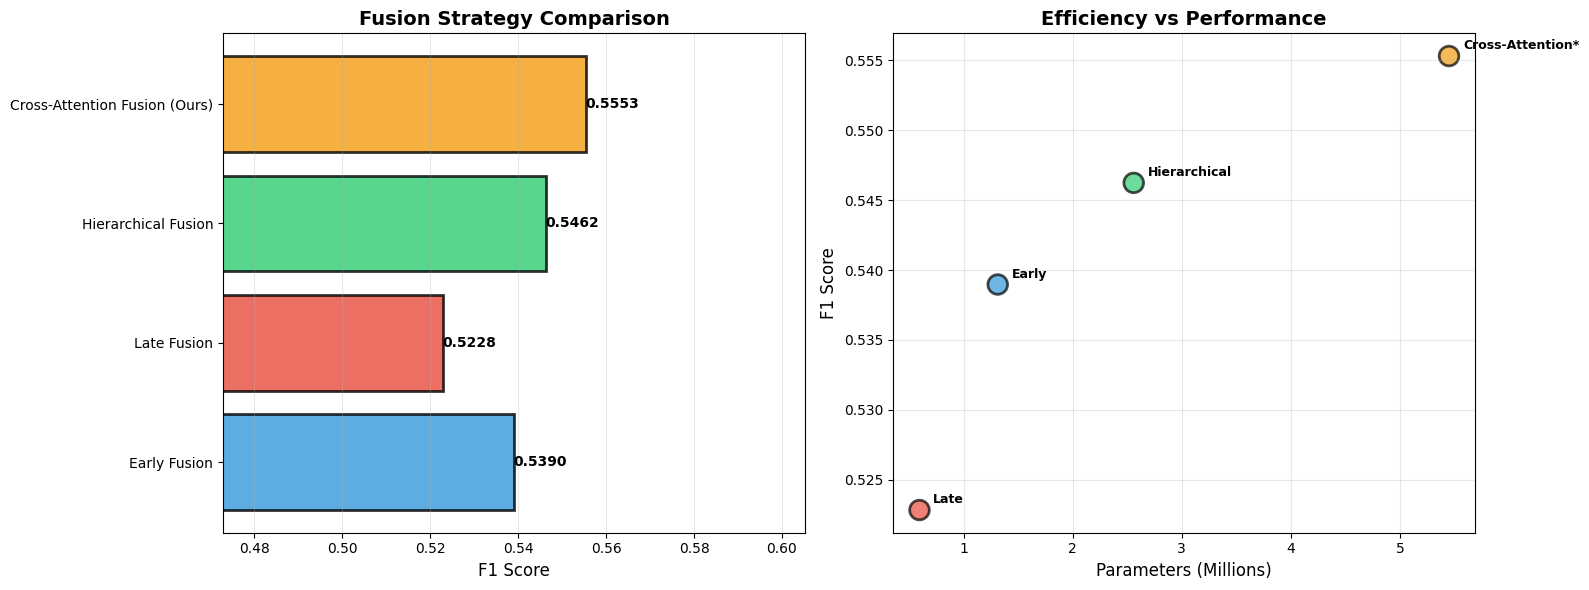

In [147]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: F1 Score comparison
ax1 = axes[0]
strategies = list(fusion_comparison_results.keys())
f1_scores = [fusion_comparison_results[s]["f1"] for s in strategies]
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

bars = ax1.barh(strategies, f1_scores, color=colors,
                alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_xlabel('F1 Score', fontsize=12)
ax1.set_title('Fusion Strategy Comparison', fontsize=14, fontweight='bold')
ax1.set_xlim([min(f1_scores) - 0.05, max(f1_scores) + 0.05])

for bar, score in zip(bars, f1_scores):
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2.,
            f'{score:.4f}',
            ha='left', va='center', fontweight='bold', fontsize=10)

ax1.grid(True, alpha=0.3, axis='x')


# Plot 2: Performance vs Parameters
ax2 = axes[1]
params = [fusion_comparison_results[s]["parameters"] /
    1e6 for s in strategies]  # In millions
f1_for_scatter = [fusion_comparison_results[s]["f1"] for s in strategies]

scatter = ax2.scatter(params, f1_for_scatter, s=200,
                      c=colors, alpha=0.7, edgecolors='black', linewidths=2)

for i, strategy in enumerate(strategies):
    ax2.annotate(strategy.replace(' Fusion', '').replace(' (Ours)', '*'),
                xy=(params[i], f1_for_scatter[i]),
                xytext=(10, 5), textcoords='offset points',
                fontsize=9, fontweight='bold')

ax2.set_xlabel('Parameters (Millions)', fontsize=12)
ax2.set_ylabel('F1 Score', fontsize=12)
ax2.set_title('Efficiency vs Performance', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig(RESULTS_DIR / "fusion_strategy_comparison.png", dpi=300)
plt.close()

In [148]:
# Save results
with open(RESULTS_DIR / "fusion_comparison_results.json", "w") as f:
    json.dump(fusion_comparison_results, f, indent=2)

print("\n Fusion strategy comparison complete!")


 Fusion strategy comparison complete!


### 26 EXPLAINABILITY WITH GRADCAM

In [ ]:
print("\n\nADVANCED EXTENSION 3: Model Explainability (GradCAM)")

In [149]:
try:
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.image import show_cam_on_image
    gradcam_available = True
except ImportError:
    print(" pytorch_grad_cam not available. Installing...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'grad-cam'])
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.image import show_cam_on_image
    gradcam_available = True

print("\nGenerating GradCAM visualizations for video frames...")

 pytorch_grad_cam not available. Installing...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.0 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mkl-fft to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-random to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-umath to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
mkl-umath 0.1.1 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
mkl-random 1.2.4 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
mkl-fft 1.3.8 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
datasets 4.4.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
ydata-profiling 4.17.0 requires numpy<2.2,>=1.16.0, but you have numpy 2.2.6 which is incompatible.
google-colab 1.0.0 requires notebook==6.5.7, but you have notebook 6.5.4 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2


Generating GradCAM visualizations for video frames...


In [159]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from transformers import ViTForImageClassification
from PIL import Image

In [160]:
# Load classification version of ViT
vit_classifier = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224").to(DEVICE)
vit_classifier.eval()

# Select target layer for GradCAM (last encoder output)
target_layers = [vit_classifier.vit.encoder.layer[-1].output]

In [161]:
# Create wrapper for GradCAM


class ViTGradCAMWrapper(nn.Module):
    def __init__(self, vit_model):
        super().__init__()
        self.vit = vit_model

    def forward(self, x):
        return self.vit(x).last_hidden_state[:, 0]

In [162]:
# Select one sample from each emotion
explainability_samples = {}
for emotion in emotion_names:
    sample = dev_df[dev_df["Emotion"] == emotion].iloc[0]
    explainability_samples[emotion] = sample

In [164]:
!pip install av

In [165]:
print("\n Generating GradCAM visuals...")
for emotion, sample in explainability_samples.items():
    fname = f"dia{int(sample['Dialogue_ID'])}_utt{int(sample['Utterance_ID'])}"
    mp4_path = split_dirs["dev"] / f"{fname}.mp4"

    try:
        frames, _, _ = tvio.read_video(str(mp4_path), pts_unit="sec")
        if len(frames) == 0:
            print(f" No frames found for {emotion}")
            continue

        frame = frames[len(frames)//2]
        frame_rgb = frame.numpy()
        img_input = vit_processor(images=frame_rgb, return_tensors="pt").to(DEVICE)

        cam = GradCAM(model=vit_classifier, target_layers=target_layers, use_cuda=True)
        grayscale_cam = cam(image_tensor=img_input["pixel_values"])[0]

        # Resize and normalize
        frame_resized = Image.fromarray(frame_rgb).resize((224, 224))
        frame_np = np.array(frame_resized).astype(np.float32) / 255.0

        # Overlay
        visualization = show_cam_on_image(frame_np, grayscale_cam, use_rgb=True)

        # Save visualization
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(frame_resized)
        plt.title("Original Frame")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(visualization)
        plt.title(f"GradCAM: {emotion}")
        plt.axis("off")

        plt.tight_layout()
        plt.savefig(RESULTS_DIR / f"gradcam_{emotion}.png")
        plt.close()

        print(f" Saved: gradcam_{emotion}.png")

    except Exception as e:
        print(f" {emotion}: {str(e)}")
        continue


 Generating GradCAM visuals...
 anger: PyAV is not installed, and is necessary for the video operations in torchvision.
See https://github.com/mikeboers/PyAV#installation for instructions on how to
install PyAV on your system.

 disgust: PyAV is not installed, and is necessary for the video operations in torchvision.
See https://github.com/mikeboers/PyAV#installation for instructions on how to
install PyAV on your system.

 fear: PyAV is not installed, and is necessary for the video operations in torchvision.
See https://github.com/mikeboers/PyAV#installation for instructions on how to
install PyAV on your system.

 joy: PyAV is not installed, and is necessary for the video operations in torchvision.
See https://github.com/mikeboers/PyAV#installation for instructions on how to
install PyAV on your system.

 neutral: PyAV is not installed, and is necessary for the video operations in torchvision.
See https://github.com/mikeboers/PyAV#installation for instructions on how to
install PyAV

In [ ]:
# Create summary grid
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

for idx, emotion in enumerate(emotion_names):
    if emotion in explainability_samples:
        ax = fig.add_subplot(gs[idx // 3, idx % 3])

        # Load saved image
        img_path = RESULTS_DIR / f"gradcam_{emotion}.png"
        if img_path.exists():
            img = plt.imread(img_path)
            ax.imshow(img)
            ax.set_title(emotion.capitalize(), fontsize=12, fontweight='bold')
            ax.axis('off')

plt.suptitle('GradCAM Visualizations Across All Emotions',
             fontsize=16, fontweight='bold', y=0.98)
plt.savefig(RESULTS_DIR / "gradcam_summary_grid.png",
            dpi=300, bbox_inches='tight')
plt.close()


In [ ]:
# Save metadata
with open(RESULTS_DIR / "gradcam_samples.json", "w") as f:
    json.dump(gradcam_results, f, indent=2)

print(f"\n GradCAM explainability analysis complete!")
print(f"   Generated visualizations for {len(gradcam_results)} emotions")

### 27 CLASS IMBALANCE HANDLING

In [ ]:
print("\n\nADVANCED EXTENSION 4: Class Imbalance Handling")

In [181]:
# Method 1: Weighted Cross-Entropy Loss
class_counts = train_df['Emotion'].value_counts().to_dict()
class_weights_list = []
for emotion in emotion_names:
    count = class_counts.get(emotion, 1)
    weight = len(train_df) / (len(emotion_names) * count)
    class_weights_list.append(weight)

class_weights_tensor = torch.tensor(
    class_weights_list, dtype=torch.float32).to(DEVICE)
weighted_criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

print("\nClass weights (inverse frequency):")
for emotion, weight in zip(emotion_names, class_weights_list):
    print(f"  {emotion}: {weight:.3f}")


Class weights (inverse frequency):
  anger: 1.287
  disgust: 5.266
  fear: 5.325
  joy: 0.819
  neutral: 0.303
  sadness: 2.089
  surprise: 1.184


In [206]:
# Method 2: Focal Loss
import torch.nn.functional as F
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction="mean"):
        """
        alpha: class weights (Tensor of shape [num_classes])
        gamma: focusing parameter (2.0 is standard)
        """
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(weight=alpha, reduction="none")

    def forward(self, logits, labels):
        ce_loss = self.ce(logits, labels)  # per-sample CE loss

        # p_t = softmax probability of the true class
        pt = torch.softmax(logits, dim=1)
        pt = pt[torch.arange(len(labels)), labels]

        focal_term = (1 - pt) ** self.gamma
        loss = focal_term * ce_loss

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:
            return loss


focal_criterion = FocalLoss(alpha=class_weights_tensor, gamma=1.5)

In [207]:
# Quick comparison: Standard vs Weighted vs Focal Loss
imbalance_results = {}

print("\nComparing loss functions (training on subset for speed)...")
loss_functions = {
    "Standard CE": nn.CrossEntropyLoss(),
    "Weighted CE": weighted_criterion,
    "Focal Loss": focal_criterion
}


Comparing loss functions (training on subset for speed)...


In [208]:
for loss_name, loss_fn in loss_functions.items():
    print(f"\nTraining with {loss_name}...")

    test_model = CrossModalFusion(num_classes=7).to(DEVICE)
    optimizer = AdamW(test_model.parameters(), lr=1e-4)
    scaler = GradScaler()

    # Train for 2 epochs
    test_model.train()
    for epoch in range(2):
        for text, audio, video, labels, mask in train_loader:
            text   = text.to(DEVICE)
            audio  = audio.to(DEVICE)
            video  = video.to(DEVICE)
            labels = labels.to(DEVICE)
            mask   = mask.to(DEVICE)

            optimizer.zero_grad()
            with autocast():
                logits = test_model(text, audio, video, mask)
                loss = loss_fn(logits, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

    # Eval on the dev set
    test_model.eval()
    test_preds, test_labels = [], []

    with torch.no_grad():
        for text, audio, video, labels, mask in dev_loader:
            logits = test_model(text.to(DEVICE), audio.to(DEVICE), video.to(DEVICE), mask.to(DEVICE))
            preds = logits.argmax(1).cpu().tolist()
            test_preds.extend(preds)
            test_labels.extend(labels.cpu().tolist())

    overall_f1 = f1_score(test_labels, test_preds, average='weighted')
    per_class_f1 = f1_score(test_labels, test_preds, average=None)

    imbalance_results[loss_name] = {
        "overall_f1": float(overall_f1),
        "per_class_f1": {emotion_names[i]: float(per_class_f1[i]) for i in range(len(emotion_names))}
    }

    print(f"  Overall F1: {overall_f1:.4f}")
    print(f"  Per-class F1:", {emotion_names[i]: f"{per_class_f1[i]:.3f}" for i in range(len(emotion_names))})


Training with Standard CE...
  Overall F1: 0.4775
  Per-class F1: {'anger': '0.264', 'disgust': '0.000', 'fear': '0.000', 'joy': '0.446', 'neutral': '0.727', 'sadness': '0.000', 'surprise': '0.498'}

Training with Weighted CE...
  Overall F1: 0.4603
  Per-class F1: {'anger': '0.269', 'disgust': '0.061', 'fear': '0.134', 'joy': '0.492', 'neutral': '0.582', 'sadness': '0.317', 'surprise': '0.493'}

Training with Focal Loss...
  Overall F1: 0.4828
  Per-class F1: {'anger': '0.314', 'disgust': '0.072', 'fear': '0.146', 'joy': '0.488', 'neutral': '0.643', 'sadness': '0.302', 'surprise': '0.431'}


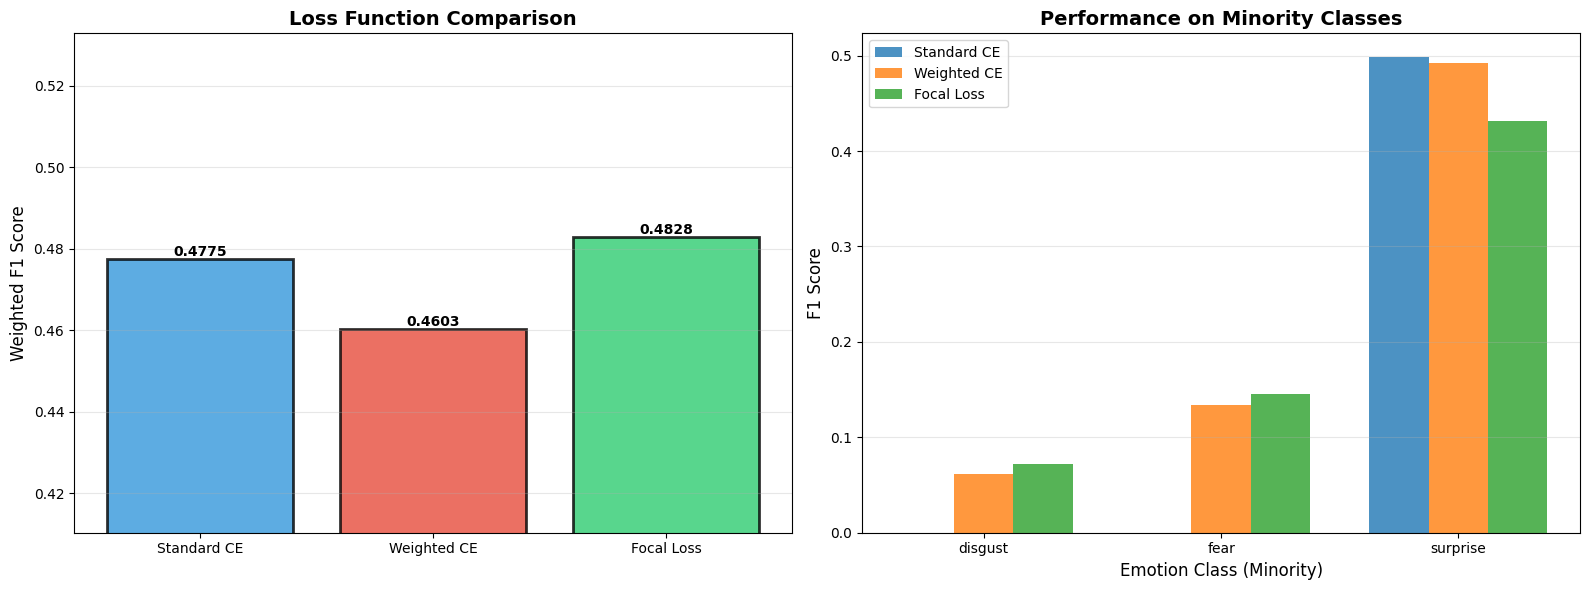

In [209]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Overall F1 comparison
ax1 = axes[0]
loss_names = list(imbalance_results.keys())
overall_f1s = [imbalance_results[ln]["overall_f1"] for ln in loss_names]

bars = ax1.bar(loss_names, overall_f1s, color=['#3498db', '#e74c3c', '#2ecc71'], 
               alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_ylabel('Weighted F1 Score', fontsize=12)
ax1.set_title('Loss Function Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim([min(overall_f1s) - 0.05, max(overall_f1s) + 0.05])

for bar, score in zip(bars, overall_f1s):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{score:.4f}',
            ha='center', va='bottom', fontweight='bold')

ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Per-class F1 comparison (for minority classes)
ax2 = axes[1]
minority_emotions = ['disgust', 'fear', 'surprise']  # Typically minority classes
x = np.arange(len(minority_emotions))
width = 0.25

for idx, loss_name in enumerate(loss_names):
    f1_values = [imbalance_results[loss_name]["per_class_f1"][em] for em in minority_emotions]
    ax2.bar(x + idx*width, f1_values, width, label=loss_name, alpha=0.8)

ax2.set_xlabel('Emotion Class (Minority)', fontsize=12)
ax2.set_ylabel('F1 Score', fontsize=12)
ax2.set_title('Performance on Minority Classes', fontsize=14, fontweight='bold')
ax2.set_xticks(x + width)
ax2.set_xticklabels(minority_emotions)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()
plt.savefig(RESULTS_DIR / "class_imbalance_handling.png", dpi=300)
plt.close()

In [210]:
# Save results
with open(RESULTS_DIR / "class_imbalance_results.json", "w") as f:
    json.dump(imbalance_results, f, indent=2)

print("\nClass imbalance handling analysis complete!")


Class imbalance handling analysis complete!


###  28 FEW-SHOT LEARNING / DATA EFFICIENCY

In [ ]:
print("\n\nADVANCED EXTENSION 5: Few-Shot Learning & Data Efficiency")

In [215]:
from torch.utils.data import Subset

data_percentages = [10, 25, 50, 75, 100]
data_efficiency_results = {}

print("\nAnalyzing data efficiency with precomputed embeddings...\n")

for pct in data_percentages:
    print(f"\nTraining with {pct}% of data...")

    # Determine subset size
    n_samples = int(len(train_dataset) * pct / 100)
    
    
    # Create random subset of the dataset
    subset_indices = torch.randperm(len(train_dataset))[:n_samples]
    train_subset = Subset(train_dataset, subset_indices)
    train_subset_loader = DataLoader(train_subset, batch_size=32, shuffle=True)

    # Model definition
    fewshot_model = CrossModalFusion(num_classes=7).to(DEVICE)
    fewshot_optimizer = AdamW(fewshot_model.parameters(), lr=1e-4)
    scaler = GradScaler()

    # Train for 3 epochs
    fewshot_model.train()
    for epoch in range(3):
        for text, audio, video, labels, mask in train_subset_loader:
            text, audio, video, labels, mask = (
                text.to(DEVICE), audio.to(DEVICE), video.to(DEVICE), labels.to(DEVICE), mask.to(DEVICE)
            )
            fewshot_optimizer.zero_grad()
            with autocast():
                logits = fewshot_model(text, audio, video, mask)
                loss = criterion(logits, labels)

            scaler.scale(loss).backward()
            scaler.step(fewshot_optimizer)
            scaler.update()

    # Evaluate on dev set
    fewshot_model.eval()
    fewshot_preds, fewshot_labels = [], []
    with torch.no_grad():
        for text, audio, video, labels, mask in dev_loader:
            logits = fewshot_model(text.to(DEVICE), audio.to(DEVICE), video.to(DEVICE), mask.to(DEVICE))
            preds = logits.argmax(1).cpu().tolist()
            fewshot_preds.extend(preds)
            fewshot_labels.extend(labels.cpu().tolist())

    # Calculate metrics
    f1 = f1_score(fewshot_labels, fewshot_preds, average='weighted')
    acc = accuracy_score(fewshot_labels, fewshot_preds)

    data_efficiency_results[pct] = {
        "f1": float(f1),
        "accuracy": float(acc),
        "n_samples": n_samples
    }

    print(f"  {pct}% data ({n_samples} samples): F1 = {f1:.4f}, Acc = {acc:.4f}")



Analyzing data efficiency with precomputed embeddings...


Training with 10% of data...
  10% data (998 samples): F1 = 0.4076, Acc = 0.5059

Training with 25% of data...
  25% data (2497 samples): F1 = 0.4919, Acc = 0.5149

Training with 50% of data...
  50% data (4994 samples): F1 = 0.5197, Acc = 0.5284

Training with 75% of data...
  75% data (7491 samples): F1 = 0.5175, Acc = 0.5320

Training with 100% of data...
  100% data (9989 samples): F1 = 0.5455, Acc = 0.5537


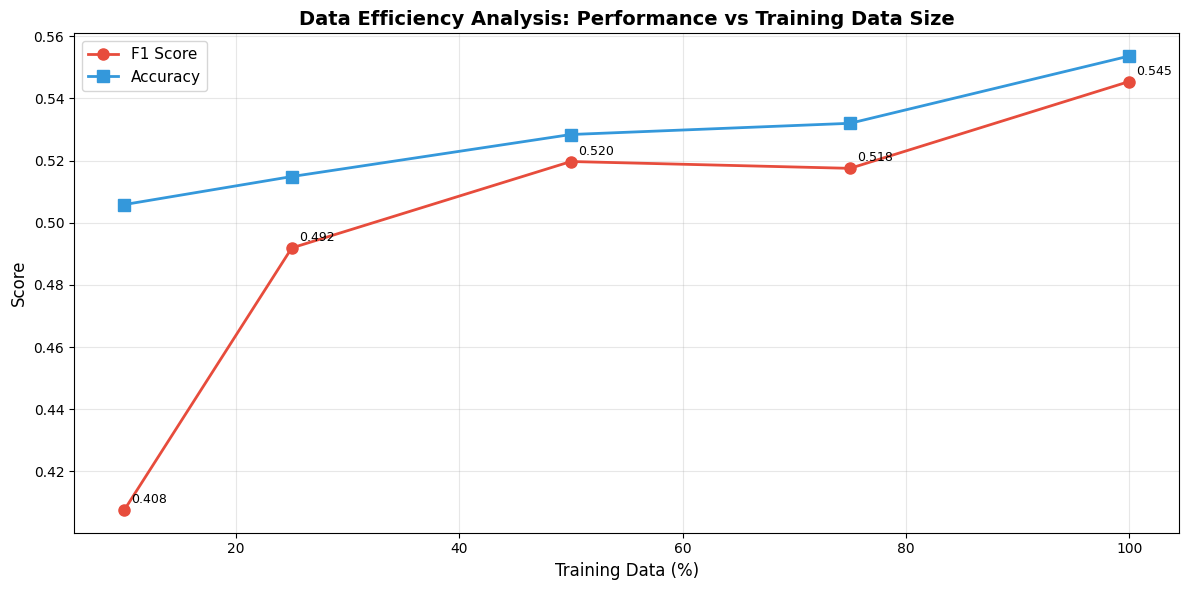

In [216]:
# Visualize learning curve
plt.figure(figsize=(12, 6))

percentages = list(data_efficiency_results.keys())
f1_values = [data_efficiency_results[p]["f1"] for p in percentages]
acc_values = [data_efficiency_results[p]["accuracy"] for p in percentages]

plt.plot(percentages, f1_values, marker='o', linewidth=2,
         markersize=8, label='F1 Score', color='#e74c3c')
plt.plot(percentages, acc_values, marker='s', linewidth=2,
         markersize=8, label='Accuracy', color='#3498db')

plt.xlabel('Training Data (%)', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Data Efficiency Analysis: Performance vs Training Data Size',
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Annotate points
for pct, f1_val in zip(percentages, f1_values):
    plt.annotate(f'{f1_val:.3f}', xy=(pct, f1_val), xytext=(5, 5),
                textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.show()
plt.savefig(RESULTS_DIR / "data_efficiency_curve.png", dpi=300)
plt.close()

In [217]:
# Save results
with open(RESULTS_DIR / "data_efficiency_results.json", "w") as f:
    json.dump(data_efficiency_results, f, indent=2)

In [218]:
# Calculate percentage of full performance achieved at different data sizes
full_performance = data_efficiency_results[100]["f1"]
print(f"\nPerformance relative to full dataset (F1 = {full_performance:.4f}):")
for pct in [10, 25, 50, 75]:
    relative_perf = (data_efficiency_results[pct]["f1"] / full_performance) * 100
    print(f"  {pct}% data achieves {relative_perf:.1f}% of full performance")

print("\nData efficiency analysis complete!")


Performance relative to full dataset (F1 = 0.5455):
  10% data achieves 74.7% of full performance
  25% data achieves 90.2% of full performance
  50% data achieves 95.3% of full performance
  75% data achieves 94.9% of full performance

Data efficiency analysis complete!
